In [16]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from natsort import natsorted
import matplotlib.pyplot as plt

In [17]:
gm_data = glob.glob("data/trained_models/2025-08-01-15 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*GM12878*.csv")
k5_data = glob.glob("data/trained_models/2025-08-01-15 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*K562*.csv")

# gm_data = [file for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
# k5_data = [file for file in (glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

# gm_data = glob.glob("data/trained_models/2025-07-31-10 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*GM12878*.csv")
# k5_data = glob.glob("data/trained_models/2025-07-31-10 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*K562*.csv")

In [18]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [19]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [20]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [21]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    ensid_matches = None
    fold_matches = None
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        # plt.clf()

        return signal_index, only_0s_index

In [22]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()
for file in data:
    df = pd.read_csv(file)
    if file[file.find("transform") + 10] == "G":
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

    # if "GM12878" in file:
    #     results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    # else:
    #     results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [23]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.470818
2     0.446886
3     0.422943
4     0.389804
5     0.438191
6     0.479069
7     0.431493
8     0.445781
9     0.432891
10    0.462855
11    0.411123
12    0.436533
Name: Error, dtype: float64

Max Error Fold: 0.4790690090090498 at Fold 6

Min Error Fold: 0.38980378977470104 at Fold 4

Mean Error: 0.4413300184792549

Max Error: 4.7115075

Min Error: 2.700000000022129e-06 

K562: 
Mean Error per Fold:
fold_idx
1     0.437861
2     0.481773
3     0.400999
4     0.372767
5     0.441374
6     0.444035
7     0.448909
8     0.516060
9     0.447196
10    0.491504
11    0.486136
12    0.504602
Name: Error, dtype: float64

Max Error Fold: 0.5160600600053804 at Fold 8

Min Error Fold: 0.3727670568887036 at Fold 4

Mean Error: 0.4611036955471574

Max Error: 4.81098988

Min Error: 2.2627413e-05 



In [24]:
gm["Pred"].min()

np.float64(-0.060476575)

Negative Predictions

GM12878: 
Threshold: 0
Genes per Fold: 
3: 12
5: 2
7: 10
9: 16
11: 29
Total Number of Matches: 69
Total Matches with >= 1 Non-Zero Value: 22
Percentage of TSSs with No Signal: 68.12%
Genes w/ Signal: ['ENSG00000237973', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000131591', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000224051_1', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000197530_2', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000178821']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000223764', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG0

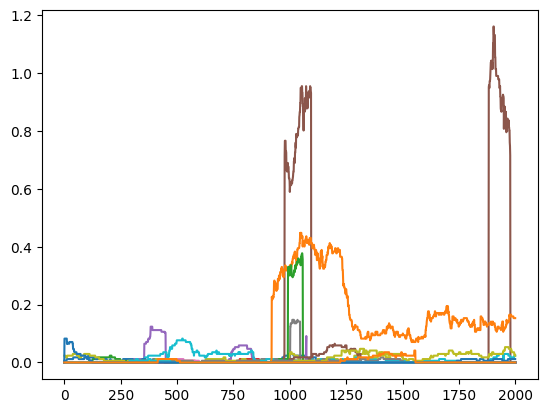

K562: 
Threshold: 0
Genes per Fold: 
1: 15
3: 240
4: 67
5: 9
6: 22
7: 118
9: 3
10: 47
12: 58
Total Number of Matches: 579
Total Matches with >= 1 Non-Zero Value: 168
Percentage of TSSs with No Signal: 70.98%
Genes w/ Signal: ['ENSG00000229344', 'ENSG00000228794_1', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000291156', 'ENSG00000186827', 'ENSG00000176022', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000205116', 'ENSG00000160072', 'ENSG00000160075_1', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000067606_1', 'ENSG00000157933', 'ENSG00000116151_1', 'ENSG00000157916', 'ENSG00000149527_1', 'ENSG00000157873_2', 'ENSG00000238164', 'ENSG00000157870', 'ENSG00000130762', 'ENSG00000130762_1', 'ENSG00000158109', 'ENSG00000116213', 'ENSG00000078900_1', 'ENSG00000097021_1', 'ENSG00000097021_3', 'ENSG00000171680_5', 'ENSG00000049247', 'ENSG00000142599_2', 'ENSG00000074800', 'ENSG00000074800_1', 'ENSG00000142583_1', 'ENSG

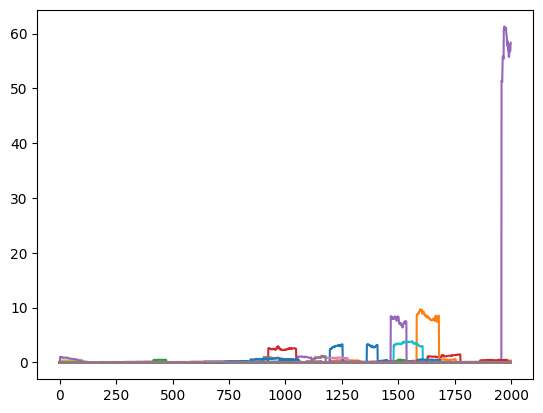

In [25]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/2025-08-01/neg_preds", "GM12878")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/2025-08-01/neg_preds", "K562")

Low Errors

In [26]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.006918
0.05    0.034543
0.10    0.062900
Name: Error, dtype: float64

In [27]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.003465
0.05    0.017968
0.10    0.035337
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001
Genes per Fold: 
1: 1
2: 4
3: 1
4: 1
5: 4
7: 6
8: 3
9: 9
10: 4
11: 6
12: 3
Total Number of Matches: 42
Total Matches with >= 1 Non-Zero Value: 22
Percentage of TSSs with No Signal: 47.62%
Genes w/ Signal: ['ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000188290', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000186827', 'ENSG000001760

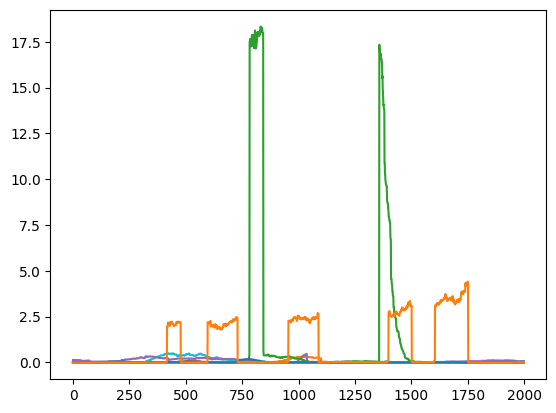

K562: 
Threshold: 0.001
Genes per Fold: 
1: 4
2: 3
3: 14
4: 23
5: 9
6: 5
7: 11
8: 1
9: 7
10: 3
11: 2
12: 3
Total Number of Matches: 85
Total Matches with >= 1 Non-Zero Value: 41
Percentage of TSSs with No Signal: 51.76%
Genes w/ Signal: ['ENSG00000225630', 'ENSG00000229344', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000160087', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000224870', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000228594', 'ENSG00000197530_1', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG

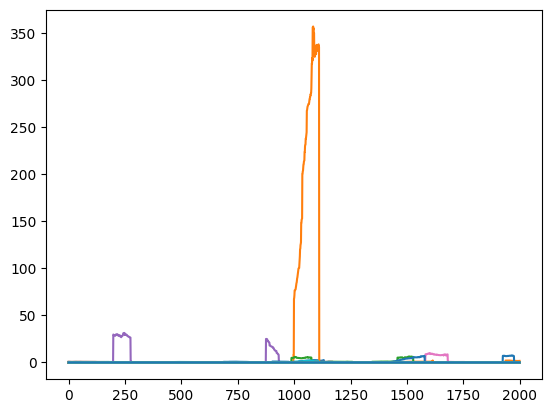

In [28]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/2025-08-01/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/2025-08-01/low_errors", "K562")

High Errors

In [29]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    0.973912
0.95    1.368329
0.99    2.256293
Name: Error, dtype: float64

In [30]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.111003
0.95    1.534457
0.99    2.272370
Name: Error, dtype: float64

GM12878: 
Threshold: 1
Genes per Fold: 
1: 314
2: 250
3: 180
4: 140
5: 225
6: 233
7: 193
8: 245
9: 233
10: 288
11: 189
12: 233
Total Number of Matches: 2723
Total Matches with >= 1 Non-Zero Value: 2309
Percentage of TSSs with No Signal: 15.20%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000162576', 'ENSG00000175756', 'ENSG0

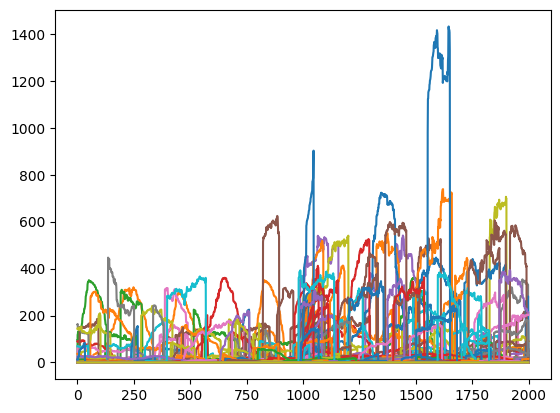

K562: 
Threshold: 1
Genes per Fold: 
1: 338
2: 318
3: 230
4: 154
5: 273
6: 253
7: 252
8: 337
9: 304
10: 383
11: 266
12: 348
Total Number of Matches: 3456
Total Matches with >= 1 Non-Zero Value: 2966
Percentage of TSSs with No Signal: 14.18%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000224

In [31]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/2025-08-01/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/2025-08-01/high_errors", "K562")

Overestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1083
2: 973
3: 678
4: 706
5: 1048
6: 705
7: 1136
8: 1081
9: 1239
10: 1474
11: 1181
12: 1170
Total Number of Matches: 12474
Total Matches with >= 1 Non-Zero Value: 8717
Percentage of TSSs with No Signal: 30.12%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000272106', 'ENSG00000197530_1', '

K562
Threshold: 0
Genes per Fold: 
1: 1123
2: 1076
3: 966
4: 587
5: 787
6: 841
7: 1021
8: 1249
9: 975
10: 1407
11: 1167
12: 1410
Total Number of Matches: 12609
Total Matches with >= 1 Non-Zero Value: 8752
Percentage of TSSs with No Signal: 30.59%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000304119', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008128', 'ENSG00

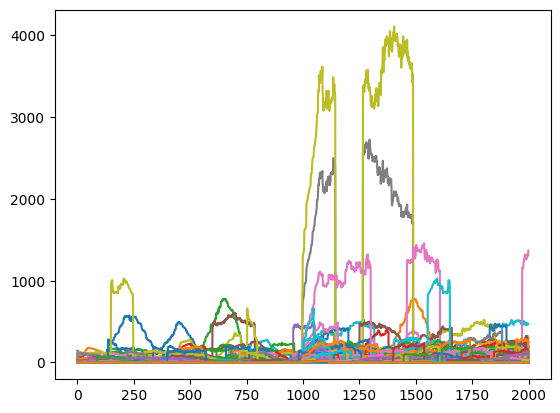

In [32]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/2025-08-01/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/2025-08-01/overestimates", "K562")

Underestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1703
2: 1620
3: 1259
4: 883
5: 1275
6: 1284
7: 953
8: 1521
9: 1259
10: 1518
11: 1078
12: 1530
Total Number of Matches: 15883
Total Matches with >= 1 Non-Zero Value: 9155
Percentage of TSSs with No Signal: 42.36%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000189339', 'ENSG00000008128', 'ENSG00000008130', 'ENSG00000078369_1', 'ENSG00000142609

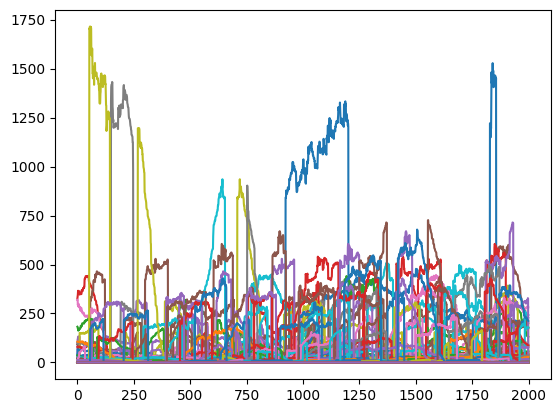

K562
Threshold: 0
Genes per Fold: 
1: 1663
2: 1517
3: 971
4: 1002
5: 1536
6: 1148
7: 1068
8: 1353
9: 1523
10: 1585
11: 1092
12: 1290
Total Number of Matches: 15748
Total Matches with >= 1 Non-Zero Value: 9339
Percentage of TSSs with No Signal: 40.70%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000242485', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000189339', 'ENSG00000008128',

In [33]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/2025-08-01/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/2025-08-01/underestimates", "K562")

Worst Errors (Over Expressed)

In [34]:
n = 5

In [35]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(n, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(n, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
10256    ENSG00000092199  3.656553     0.0         5                     NaN   
24569    ENSG00000165672  3.336867     0.0        11                     NaN   
9906     ENSG00000100804  3.262193     0.0         5                     NaN   
2433     ENSG00000173660  3.173971     0.0         1                     NaN   
17848  ENSG00000130592_1  3.093800     0.0         8                     NaN   

          Error  Signed Error  
10256  3.656553      3.656553  
24569  3.336867      3.336867  
9906   3.262193      3.262193  
2433   3.173971      3.173971  
17848  3.093800      3.093800

K562: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
9026   ENSG00000274012  3.517636     0.0         5                 310.960   
2309   ENSG00000117748  3.408384     0.0         1                 881.266   
2732   ENSG00000143106  3.406188     0.0         1                2220.680   
286    ENSG00000173660  3.215000     0.0         1                     NaN   
17489  ENSG00000213593  3.175667     0.0         8                     NaN   

          Error  Signed Error  
9026   3.517636      3.517636  
2309   3.408384      3.408384  
2732   3.406188      3.406188  
286    3.215000      3.215000  
17489  3.175667      3.175667

GM12878: 


Pred: 3.173971
Actual: 0.0


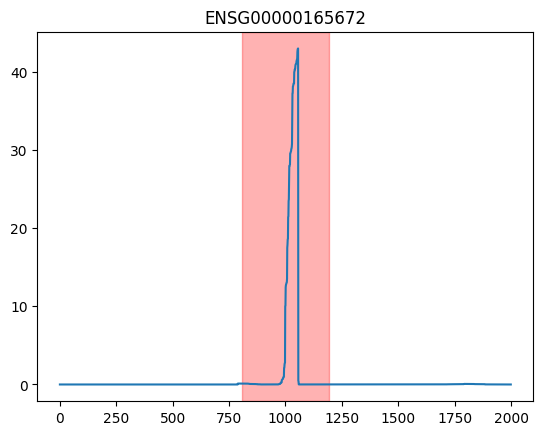

Pred: 3.3368673
Actual: 0.0


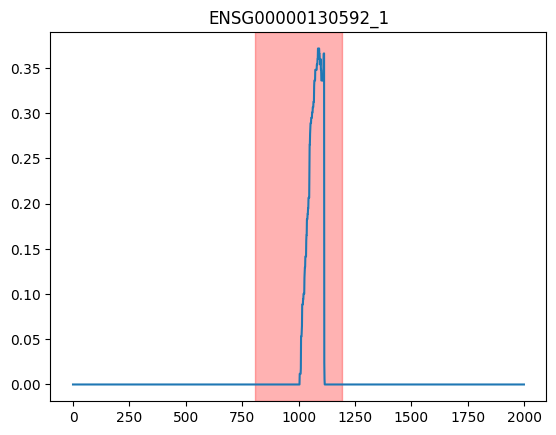

Pred: 3.0938005
Actual: 0.0


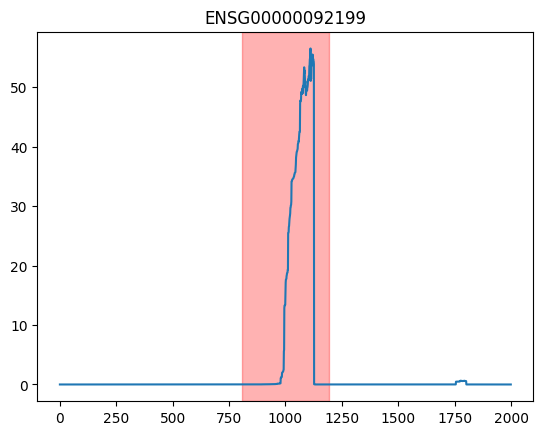

Pred: 3.6565533
Actual: 0.0


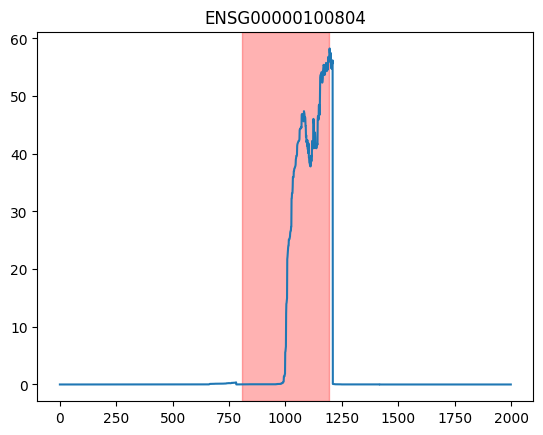

Pred: 3.262193
Actual: 0.0

K562: 


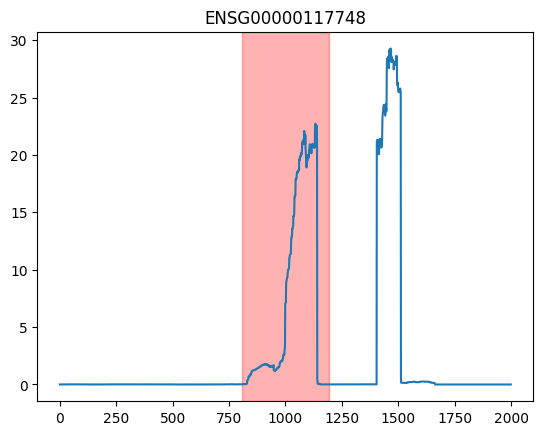

Pred: 3.4083843
Actual: 0.0


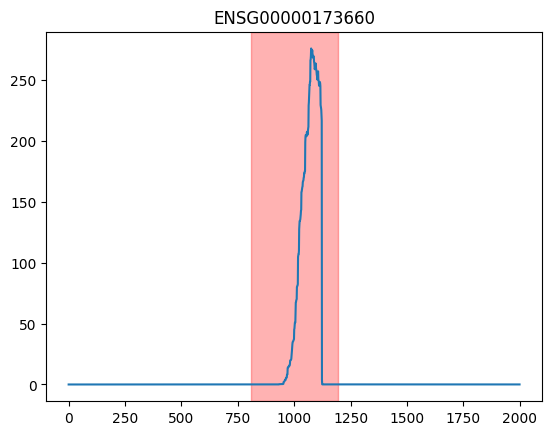

Pred: 3.2150004
Actual: 0.0


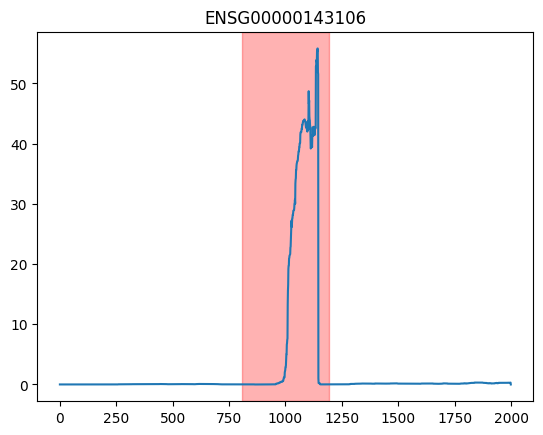

Pred: 3.4061878
Actual: 0.0


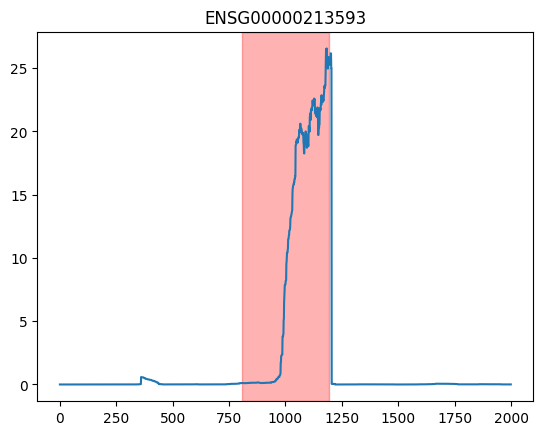

Pred: 3.175667
Actual: 0.0


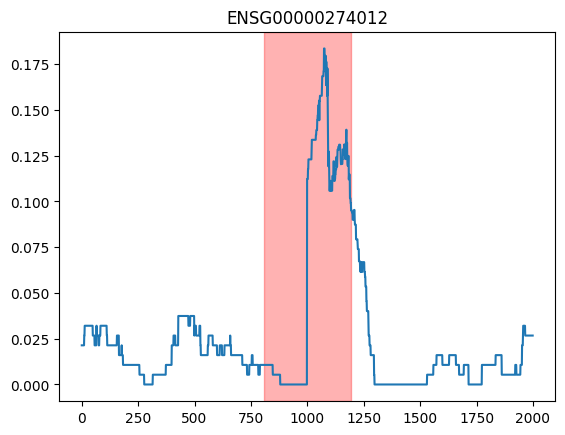

Pred: 3.5176363
Actual: 0.0


In [36]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

Worst Errors (Under Expressed)

In [37]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(n, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(n, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
25137  ENSG00000272160  0.065878  4.697162        11                49791.30   
19132  ENSG00000202538  1.678511  5.662860         9               460107.00   
1386   ENSG00000143185  0.132781  3.915335         1                 8227.76   
10394  ENSG00000232216  0.230318  3.394305         5                 2478.16   
27424  ENSG00000253506  0.489368  3.642420        12                 4388.55   

          Error  Signed Error  
25137  4.631284     -4.631284  
19132  3.984349     -3.984349  
1386   3.782554     -3.782554  
10394  3.163986     -3.163986  
27424  3.153052     -3.153052

K562: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
19073  ENSG00000200795  1.272412  5.147695         9               260205.00   
13188  ENSG00000233440  0.136078  3.252559         6                  466.40   
18798  ENSG00000180574  0.048756  3.124833         9                 1220.50   
26368  ENSG00000253506  0.278919  3.284126        12                 4388.55   
635    ENSG00000240409  1.131708  4.121724         1                17244.00   

          Error  Signed Error  
19073  3.875283     -3.875283  
13188  3.116481     -3.116481  
18798  3.076077     -3.076077  
26368  3.005207     -3.005207  
635    2.990016     -2.990016

GM12878: 


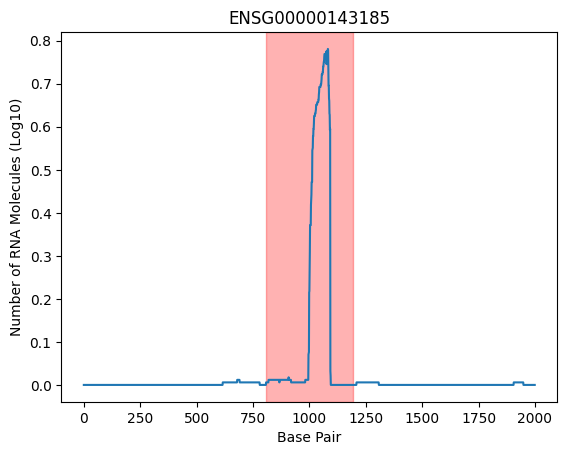

Pred: 0.13278076
Actual: 3.9153345


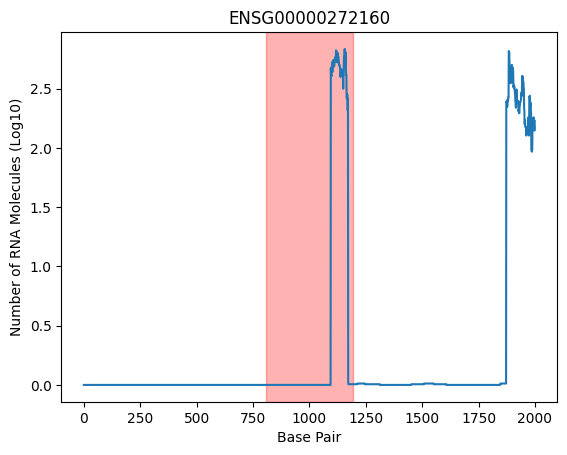

Pred: 0.06587833
Actual: 4.697162


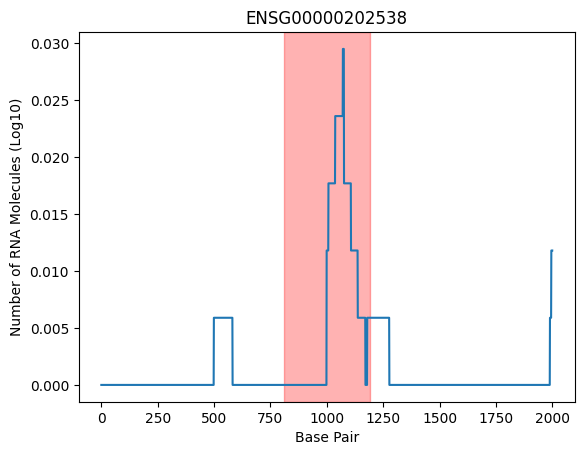

Pred: 1.6785109
Actual: 5.66286


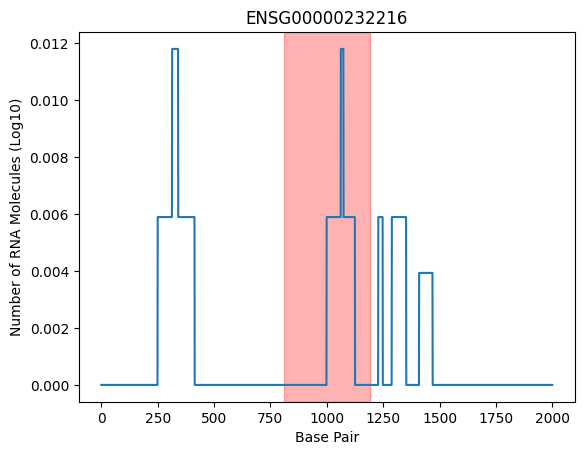

Pred: 0.23031816
Actual: 3.3943045


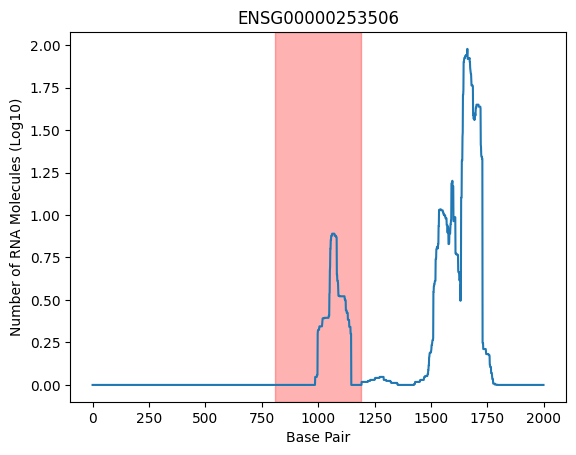

Pred: 0.4893676
Actual: 3.64242

K562: 


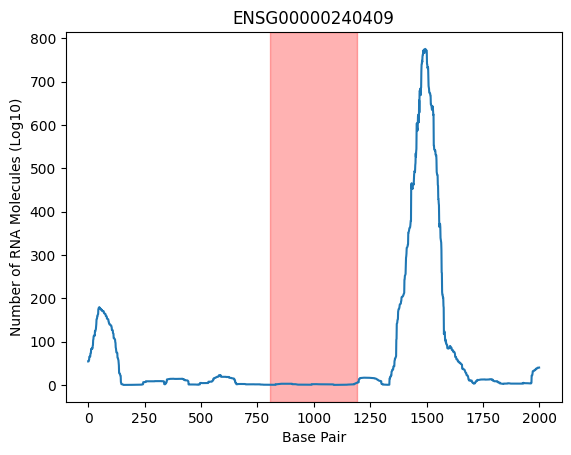

Pred: 1.1317078
Actual: 4.121724


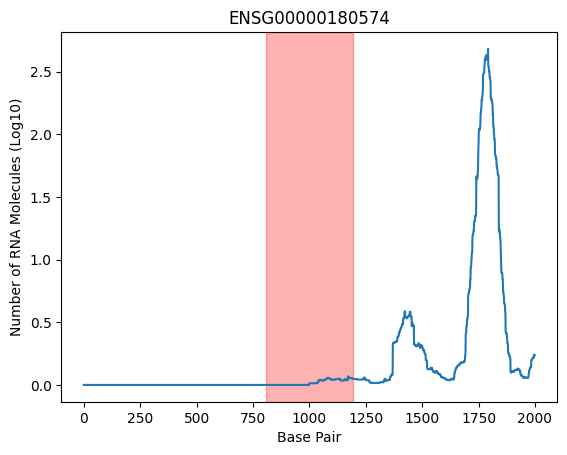

Pred: 0.04875645
Actual: 3.1248333


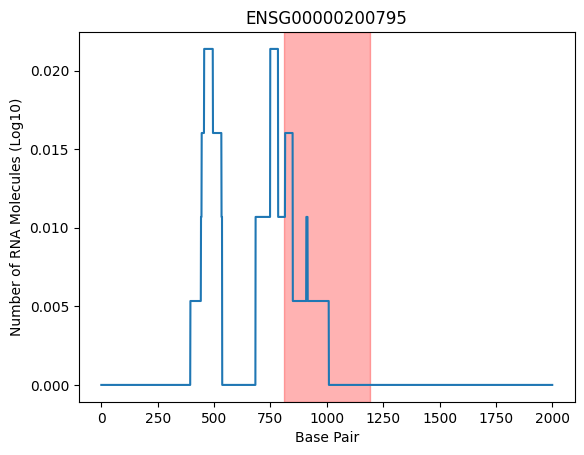

Pred: 1.2724121
Actual: 5.147695


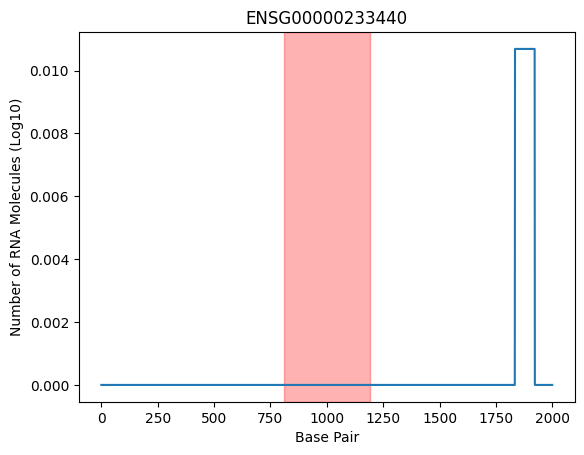

Pred: 0.13607846
Actual: 3.2525594


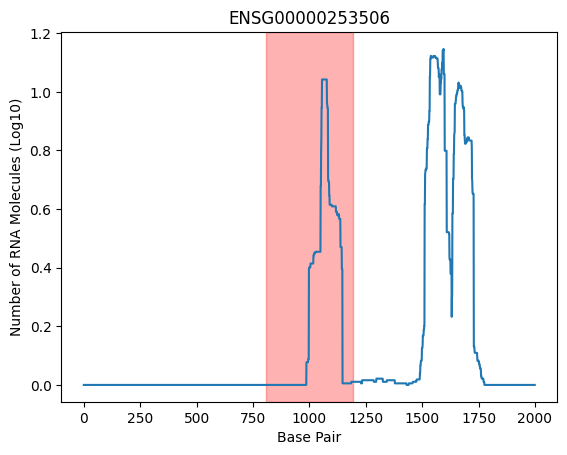

Pred: 0.27891907
Actual: 3.284126


In [38]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_worst_under_gm = 10 ** signal_5_worst_under_gm - 1
# signal_5_worst_under_k5 = 10 ** signal_5_worst_under_k5 - 1

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

Best Errors (Over Expressed)

In [39]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(n, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
25374    ENSG00000176953  2.750141  2.750138        11   
15584  ENSG00000168066_1  3.397273  3.397246         8   
18201    ENSG00000121351  0.000202  0.000000         9   
24104    ENSG00000242147 -0.000270  0.000000        11   
18753    ENSG00000010626  0.547747  0.547382         9   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
25374               561.52000  0.000003      0.000003  
15584              2495.01000  0.000027      0.000027  
18201                     NaN  0.000202      0.000202  
24104                     NaN  0.000270     -0.000270  
18753                 2.52681  0.000365      0.000365

K562: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
24970  ENSG00000187714  1.426799  1.426885        11                  20.807   
18590  ENSG00000089250  1.467631  1.467815         9                  23.327   
18552  ENSG00000090470  2.542506  2.542203         9                 503.140   
20311  ENSG00000258056  2.042914  2.043248         9                 105.098   
19116  ENSG00000134532  0.000360  0.000000         9                     NaN   

          Error  Signed Error  
24970  0.000086     -0.000086  
18590  0.000185     -0.000185  
18552  0.000303      0.000303  
20311  0.000334     -0.000334  
19116  0.000360      0.000360

GM12878: 


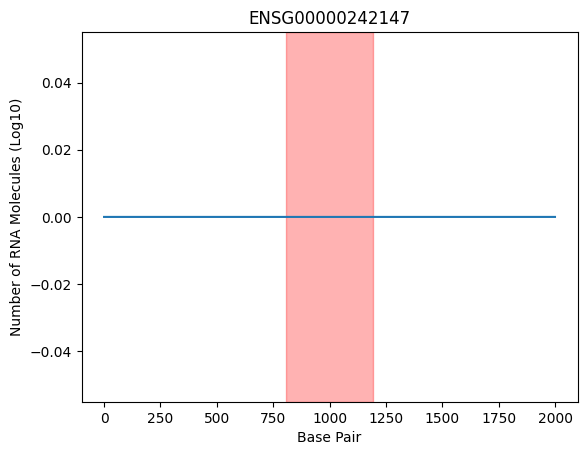

Pred: -0.0002702959
Actual: 0.0


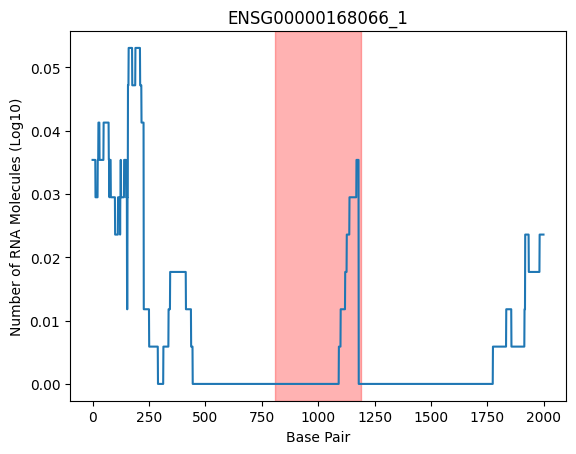

Pred: 3.3972733
Actual: 3.3972464


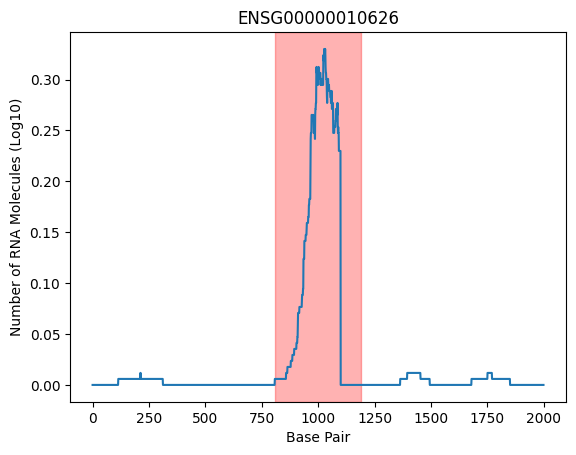

Pred: 0.5477469
Actual: 0.54738206


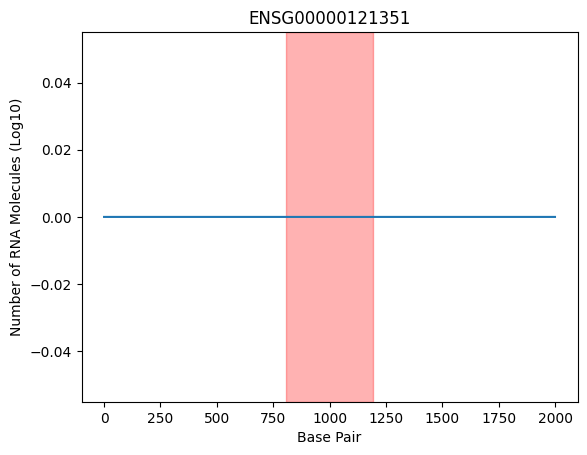

Pred: 0.00020249747
Actual: 0.0


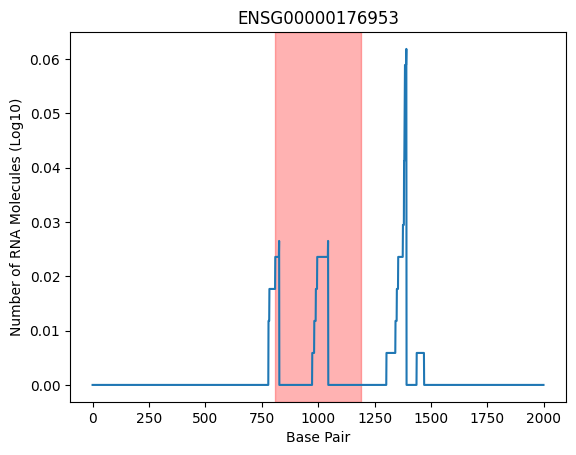

Pred: 2.7501407
Actual: 2.750138

K562: 


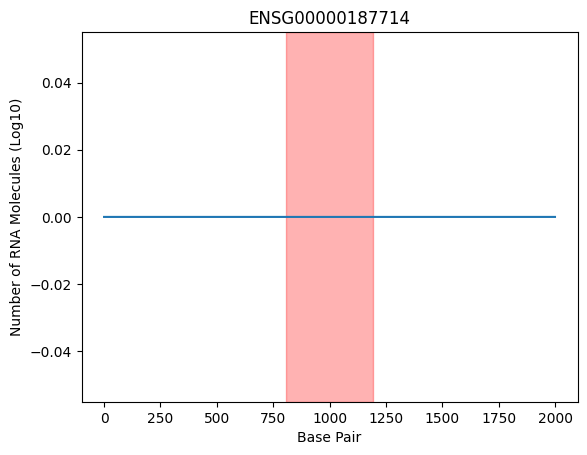

Pred: 1.4267989
Actual: 1.4268852


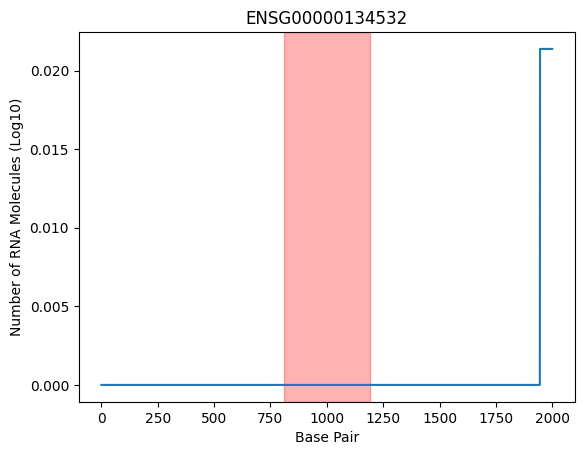

Pred: 0.00035998225
Actual: 0.0


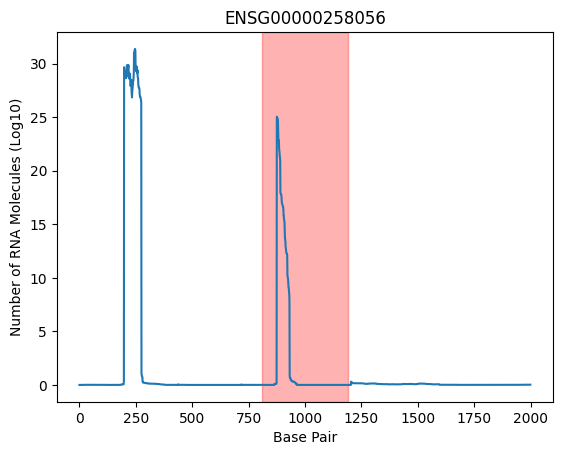

Pred: 2.0429144
Actual: 2.0432482


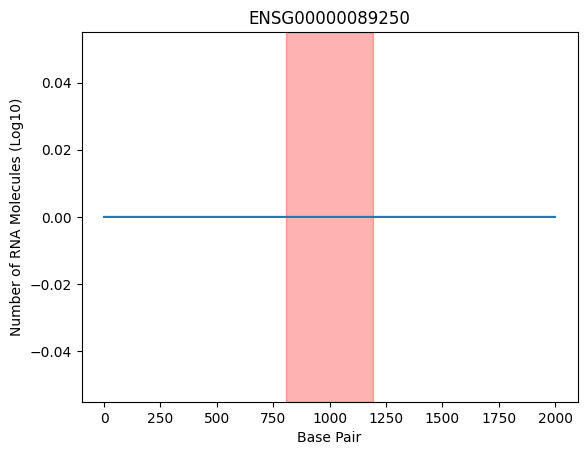

Pred: 1.4676306
Actual: 1.4678152


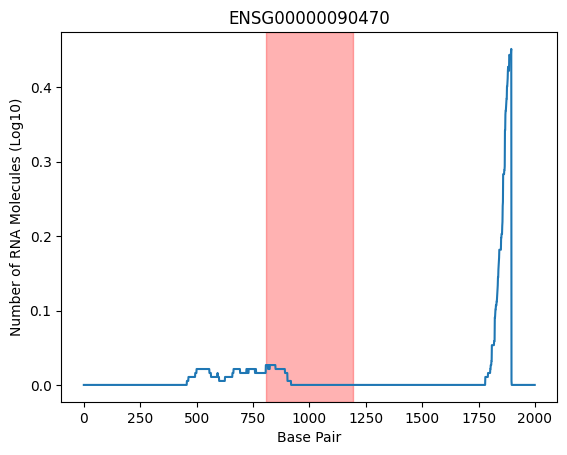

Pred: 2.5425057
Actual: 2.5422027


In [40]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

Best Errors (Under Expressed)

In [41]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(n, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
1997     ENSG00000160087  2.819674  2.819679         1   
18201    ENSG00000121351  0.000202  0.000000         9   
20775    ENSG00000105711  1.261213  1.260858        10   
18478    ENSG00000111291  0.000382  0.000000         9   
23205  ENSG00000131408_2  2.638979  2.638471        10   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
1997                  659.206  0.000005     -0.000005  
18201                     NaN  0.000202      0.000202  
20775                  17.233  0.000355      0.000355  
18478                     NaN  0.000382      0.000382  
23205                 433.982  0.000508      0.000508

K562: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
24970  ENSG00000187714  1.426799  1.426885        11                  20.807   
15365  ENSG00000133316  2.851127  2.850867         8                 634.031   
18552  ENSG00000090470  2.542506  2.542203         9                 503.140   
23059  ENSG00000197332  1.875601  1.875293        10                  12.962   
4837   ENSG00000084676  2.165677  2.165998         2                 272.640   

          Error  Signed Error  
24970  0.000086     -0.000086  
15365  0.000260      0.000260  
18552  0.000303      0.000303  
23059  0.000308      0.000308  
4837   0.000321     -0.000321

GM12878: 


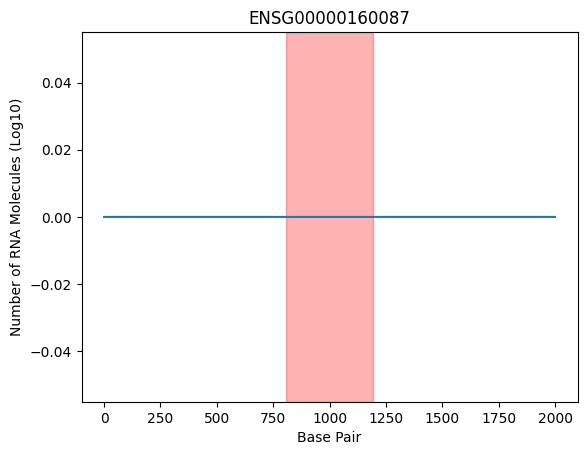

Pred: 2.819674
Actual: 2.8196795


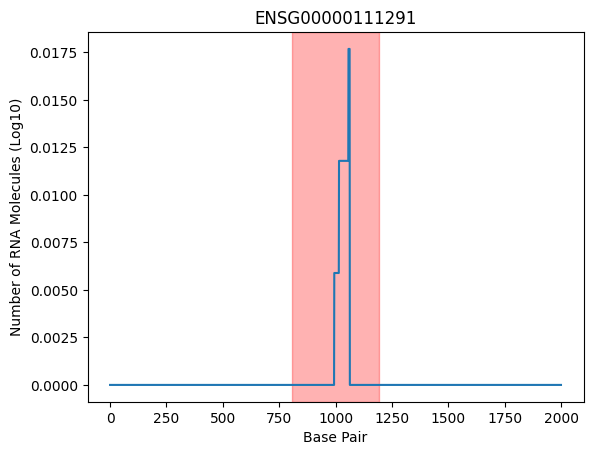

Pred: 0.00038227625
Actual: 0.0


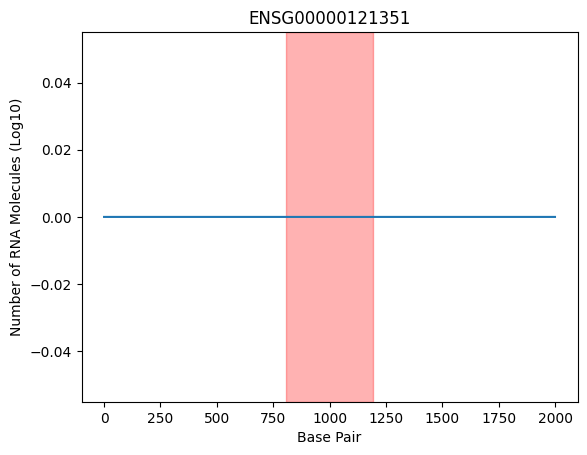

Pred: 0.00020249747
Actual: 0.0


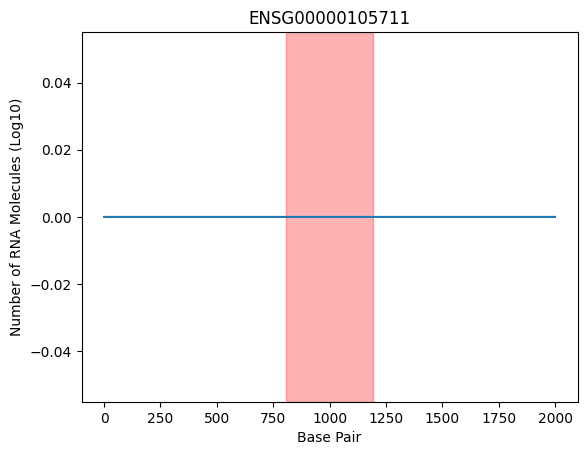

Pred: 1.2612128
Actual: 1.2608582


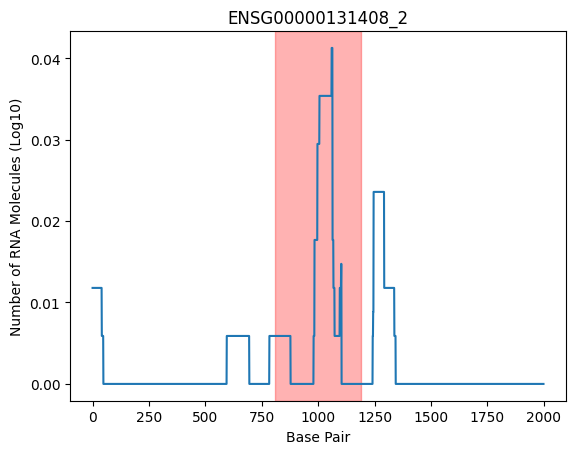

Pred: 2.638979
Actual: 2.6384714

K562: 


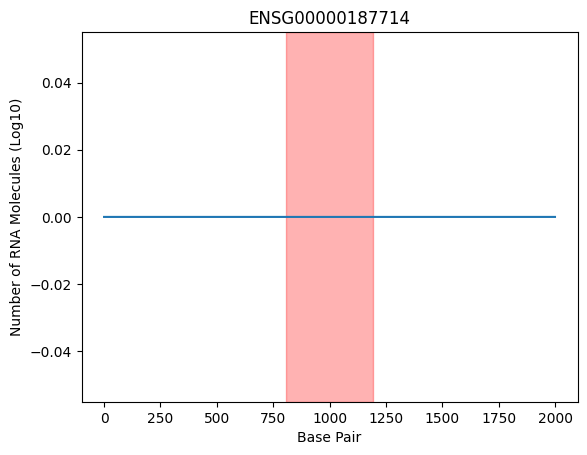

Pred: 1.4267989
Actual: 1.4268852


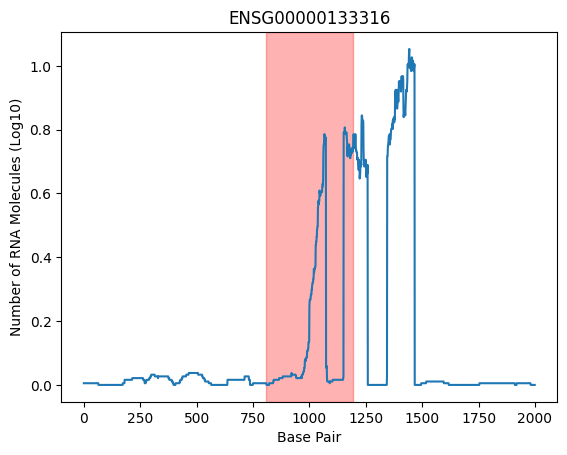

Pred: 2.8511267
Actual: 2.8508668


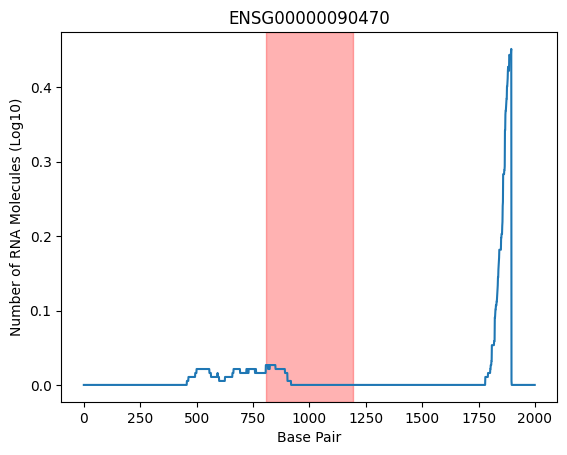

Pred: 2.5425057
Actual: 2.5422027


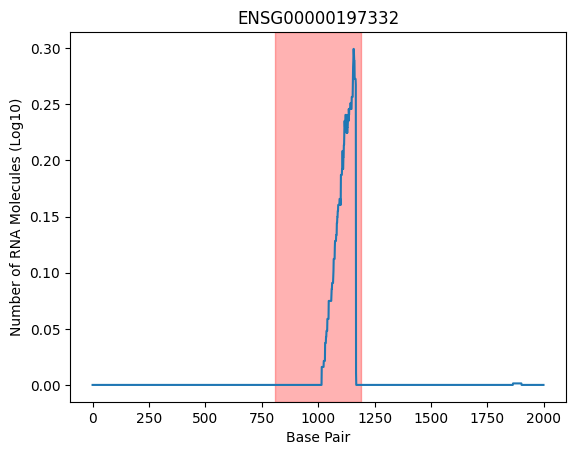

Pred: 1.8756008
Actual: 1.8752928


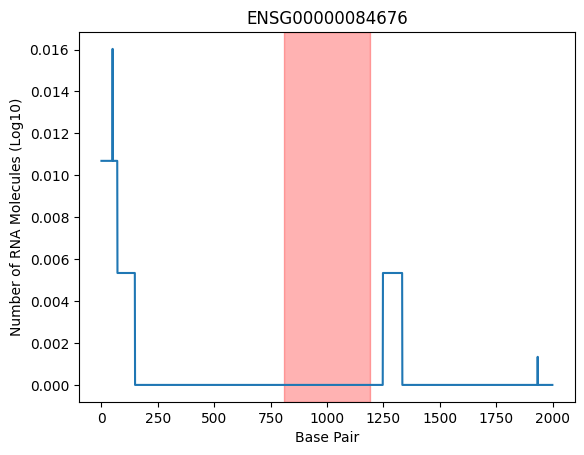

Pred: 2.1656768
Actual: 2.1659977


In [42]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_best_under_gm = 10 ** signal_5_best_under_gm - 1
# signal_5_best_under_k5 = 10 ** signal_5_best_under_k5 - 1

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_best_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_under_k5):
    plt.plot(signal_5_best_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-08-01/underestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

Zero Signal (Actual)

GM12878: 
Threshold: 0
Genes per Fold: 
1: 981
2: 822
3: 710
4: 617
5: 783
6: 649
7: 652
8: 815
9: 805
10: 909
11: 618
12: 719
Total Number of Matches: 9080
Total Matches with >= 1 Non-Zero Value: 4129
Percentage of TSSs with No Signal: 54.53%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000198744', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187961', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG00000197921', 'ENSG00000157873_1', 'ENSG00000157873_2', 'ENSG00000238164', 'ENSG00000130762', 

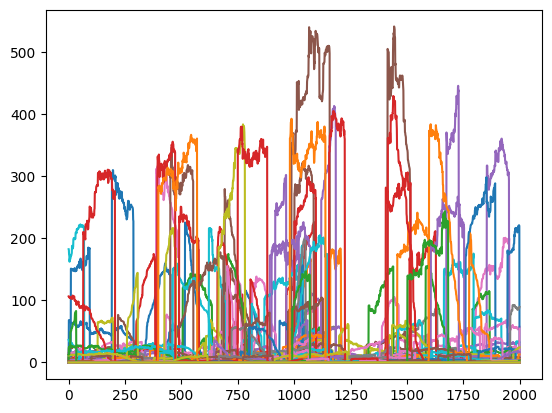

K562: 
Threshold: 0
Genes per Fold: 
1: 1253
2: 1155
3: 928
4: 772
5: 1085
6: 846
7: 862
8: 1108
9: 1116
10: 1237
11: 843
12: 1040
Total Number of Matches: 12245
Total Matches with >= 1 Non-Zero Value: 6246
Percentage of TSSs with No Signal: 48.99%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187961', 'ENSG00000188157', 'ENSG00000131591', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000175756', 'ENSG00000179403', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000142609_1', 'ENSG00000187730', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG0000015

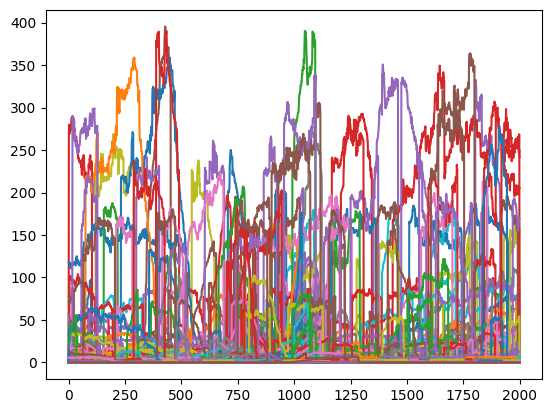

In [43]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/2025-08-01/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/2025-08-01/zero", "K562")

Aggregate FP, FN, TP, TN

In [44]:
# GM12878
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    preds = [actuals[idx] if gm["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in gm["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": gm["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "Pred": [gm["actual"].iloc[idx] > best_threshold if gm["Error"].iloc[idx] < 1.5 else 1 - (gm["actual"].iloc[idx] > best_threshold) for idx, pred in gm["Pred"].items()],
    "fold_idx": gm["fold_idx"]
}
gm_binary = pd.DataFrame(pred_actual) 

# K562
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in k5["actual"]]
    preds = [actuals[idx] if k5["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in k5["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": k5["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in k5["actual"]],
    "Pred": [k5["actual"].iloc[idx] > best_threshold if k5["Error"].iloc[idx] < 1.5 else 1 - (k5["actual"].iloc[idx] > best_threshold) for idx, pred in k5["Pred"].items()],
    "fold_idx": k5["fold_idx"]
}
k5_binary = pd.DataFrame(pred_actual) 


Best Threshold: 0.0 w/ 0.9710568106142103 F1 Score
Best Threshold: 0.0 w/ 0.9543141019779952 F1 Score


In [45]:
# GM12878
fp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 0)]
fn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 1)]
tp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 1)]
tn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 0)]

In [46]:
# GM12878
a = [fp_gm, fn_gm, tp_gm, tn_gm]
for b in a:
    print(len(b))

809
321
18956
8271


In [47]:
# GM12878
dfs = {"False Positive": fp_gm, 
       "False Negative": fn_gm, 
       "True Positive": tp_gm, 
       "True Negative": tn_gm}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in gm_h5["ensid"]]
    rna = gm_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
    plt.savefig(f"predictions/2025-08-01/aggregate_confusion/gm_{title}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [48]:
# K562
fp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 0)]
fn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 1)]
tp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 1)]
tn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 0)]

In [49]:
# K562
a = [fp_k5, fn_k5, tp_k5, tn_k5]
for b in a:
    print(len(b))

1043
456
15656
11202


In [50]:
# K562
dfs = {"False Positive": fp_k5, 
       "False Negative": fn_k5, 
       "True Positive": tp_k5, 
       "True Negative": tn_k5}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in k5_h5["ensid"]]
    rna = k5_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
#     plt.show()
    plt.savefig(f"predictions/2025-08-01/aggregate_confusion/k5_{title}.png")
    plt.clf()



<Figure size 640x480 with 0 Axes>

Find genes with strong peaks in false positives

Threshold: 0.0
Number of Genes w/ Strong Peaks: 402


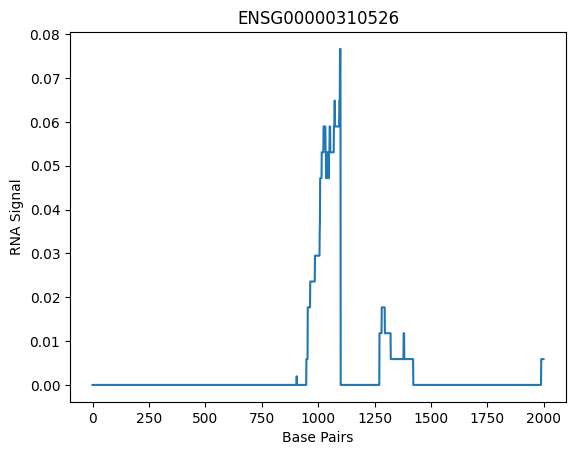

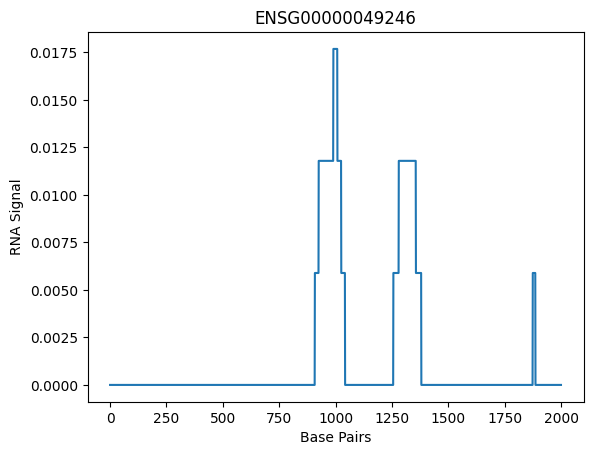

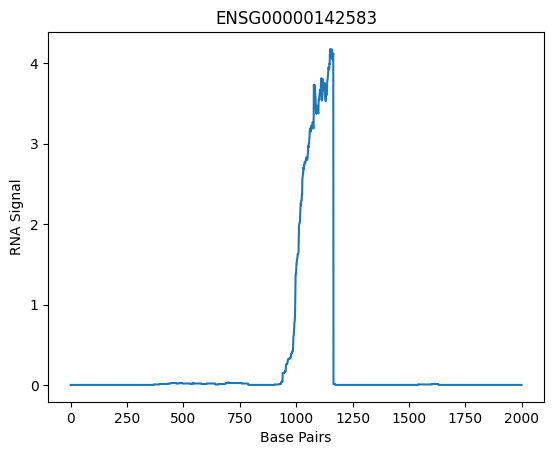

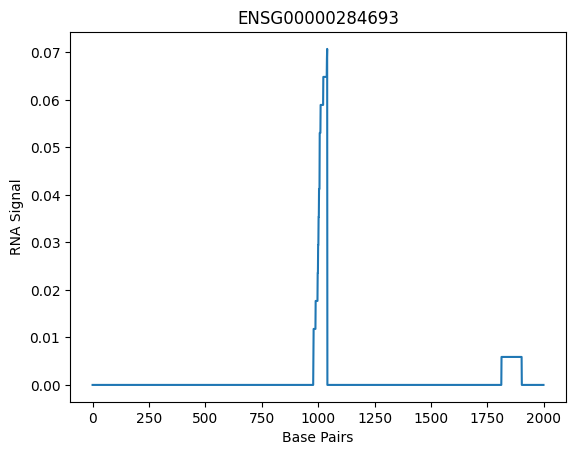

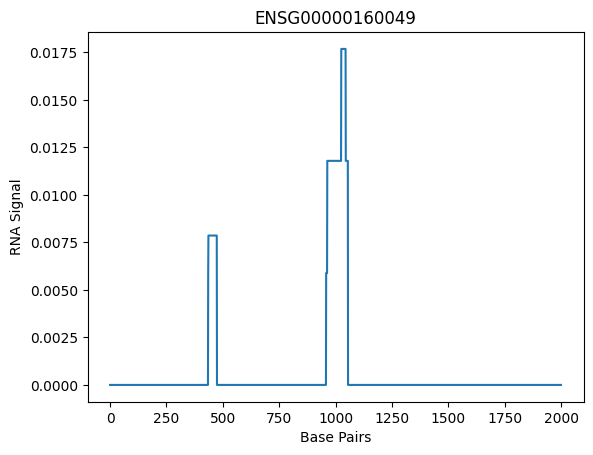

Threshold: 0.5
Number of Genes w/ Strong Peaks: 229


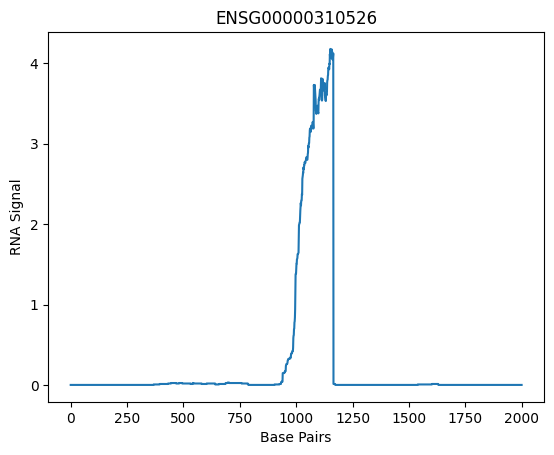

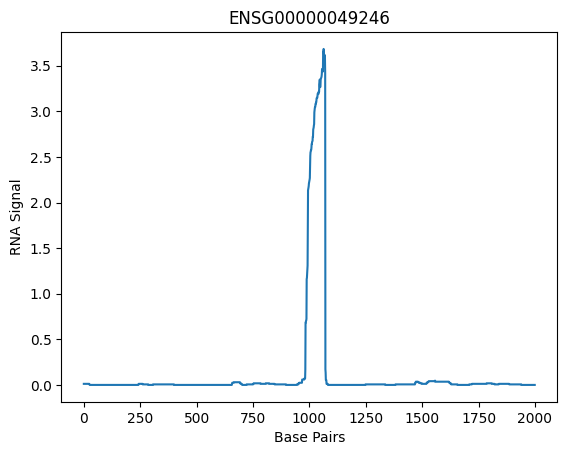

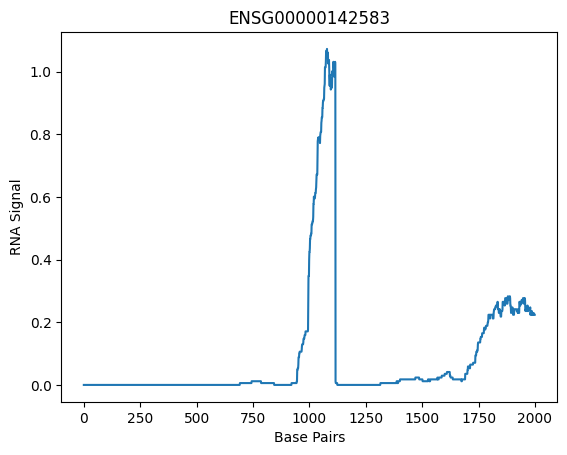

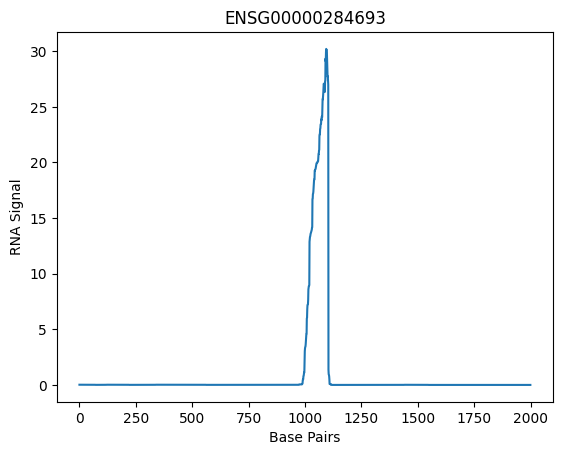

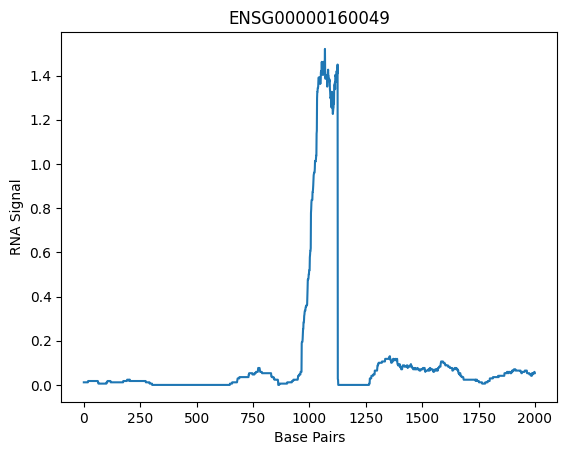

Threshold: 1.0
Number of Genes w/ Strong Peaks: 182


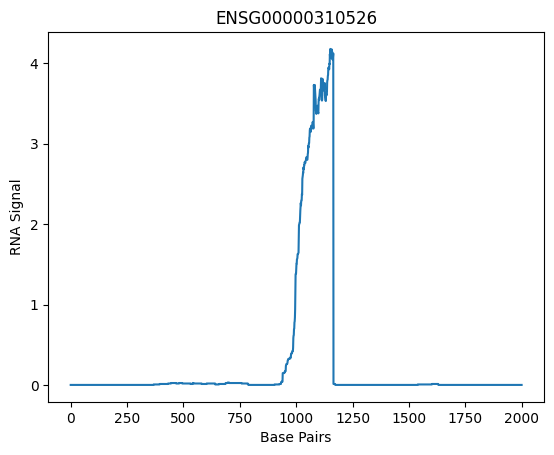

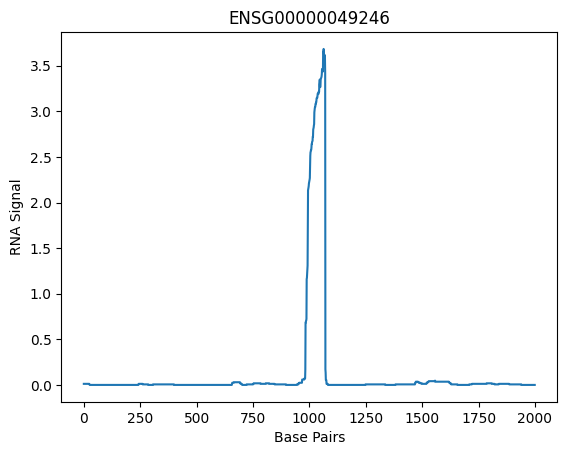

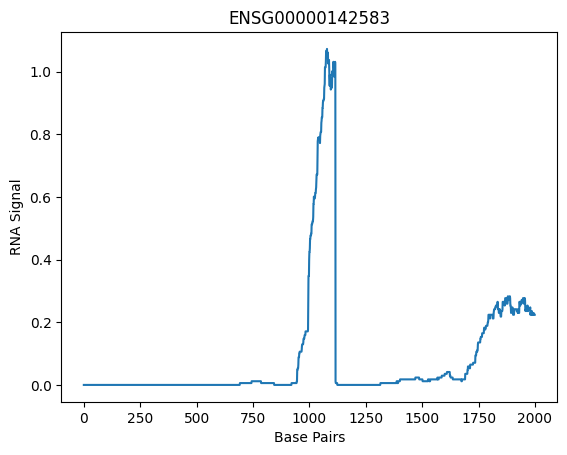

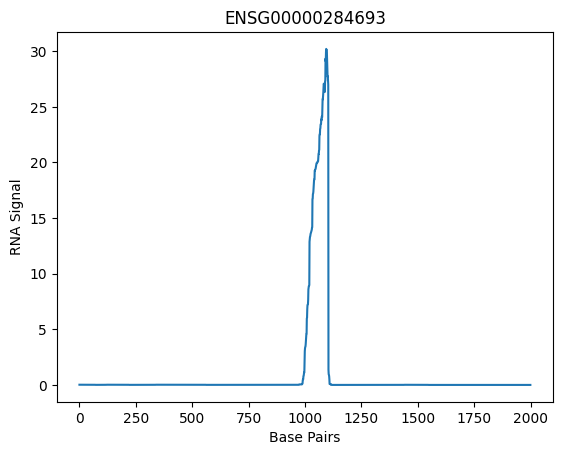

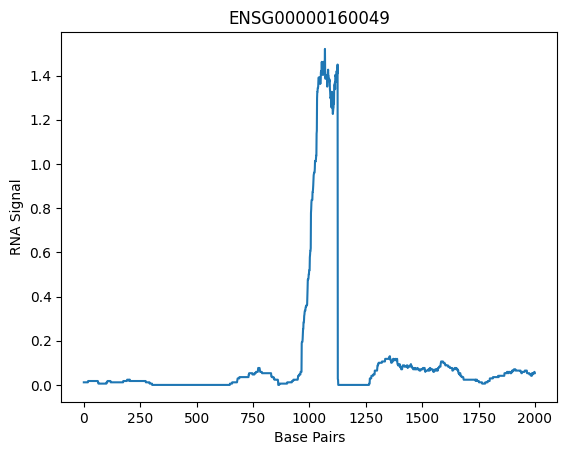

Threshold: 1.5
Number of Genes w/ Strong Peaks: 155


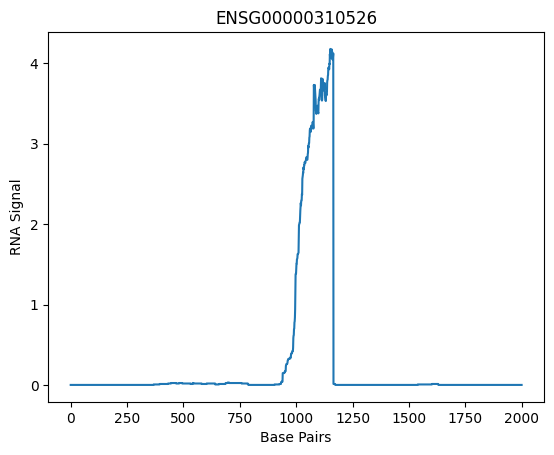

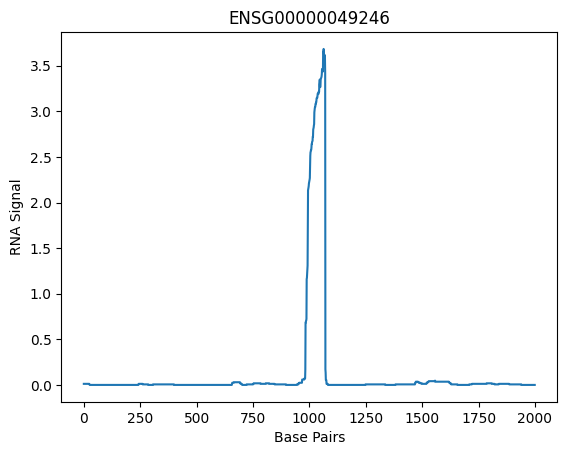

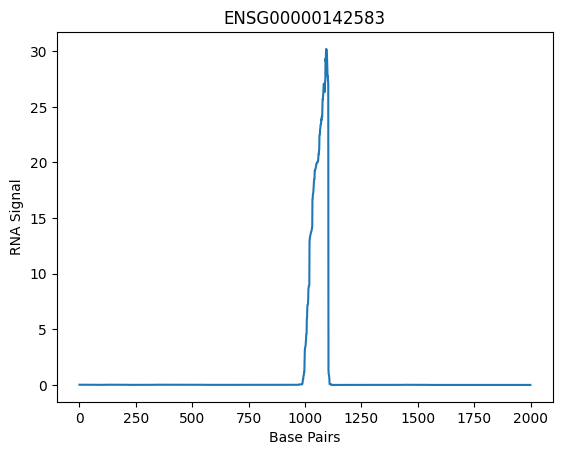

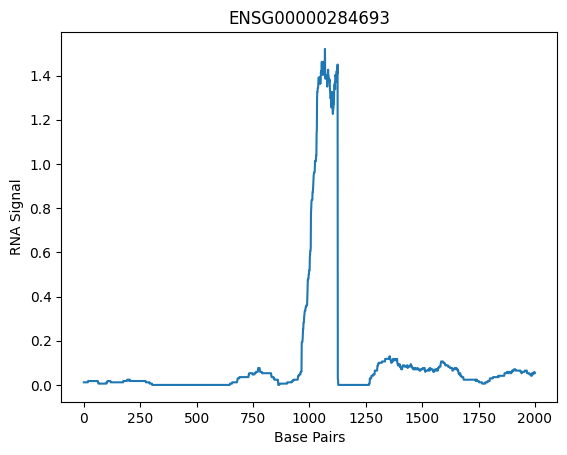

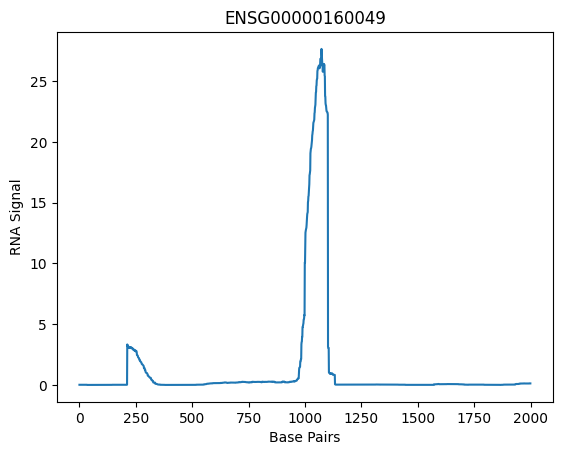

Threshold: 2.0
Number of Genes w/ Strong Peaks: 137


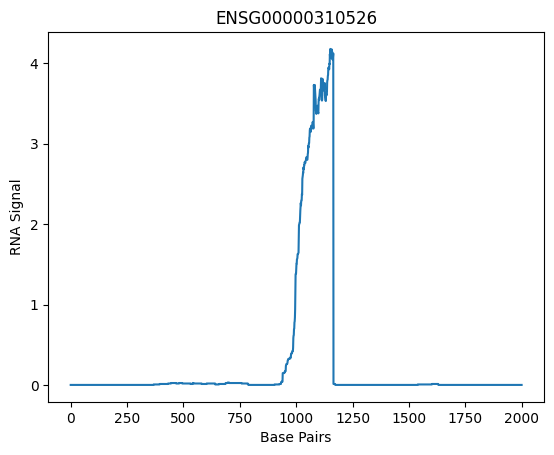

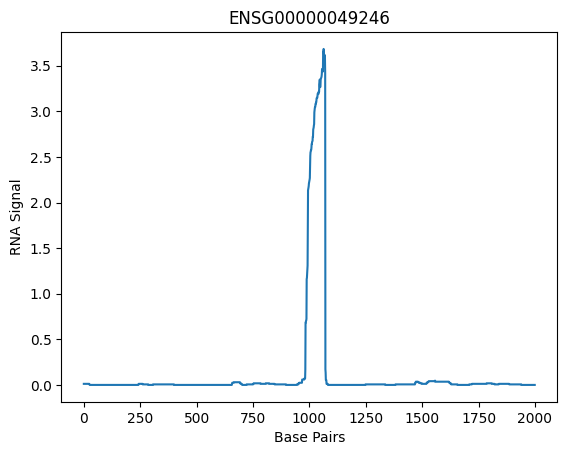

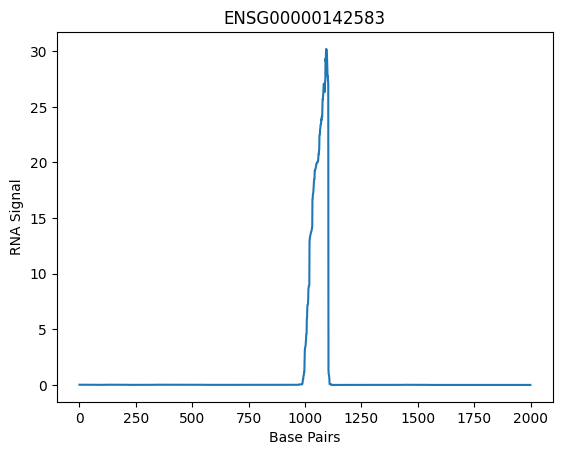

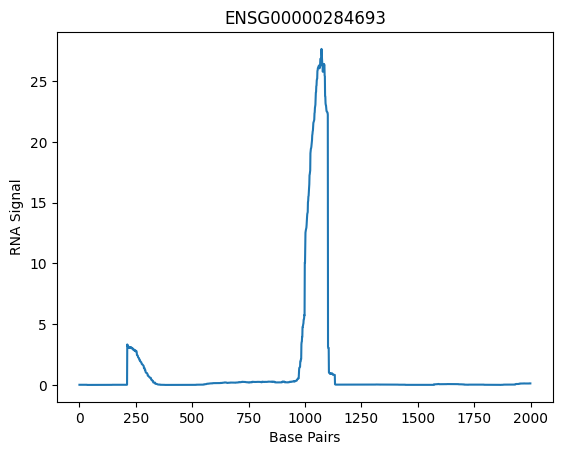

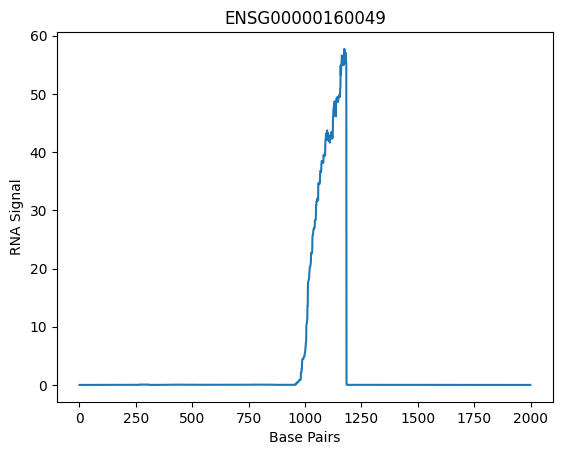

Threshold: 2.5
Number of Genes w/ Strong Peaks: 125


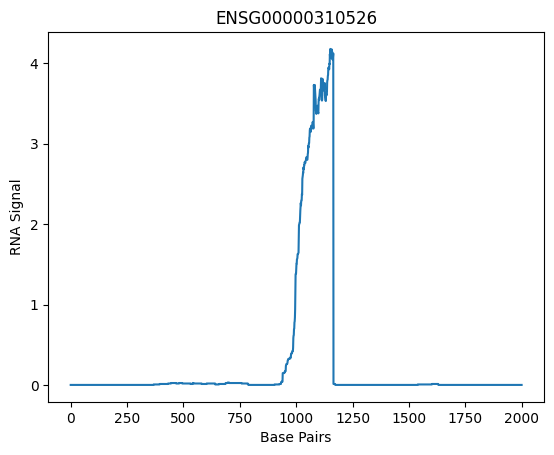

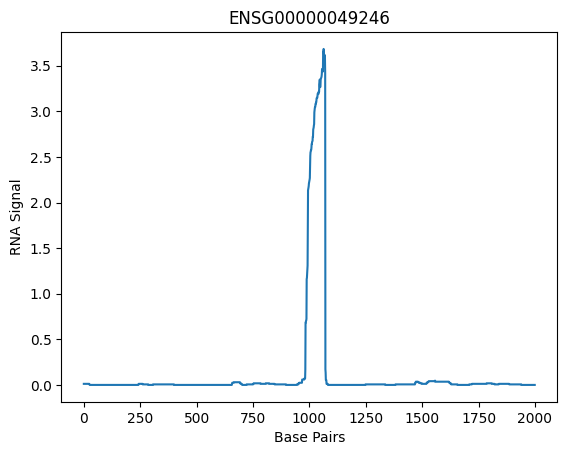

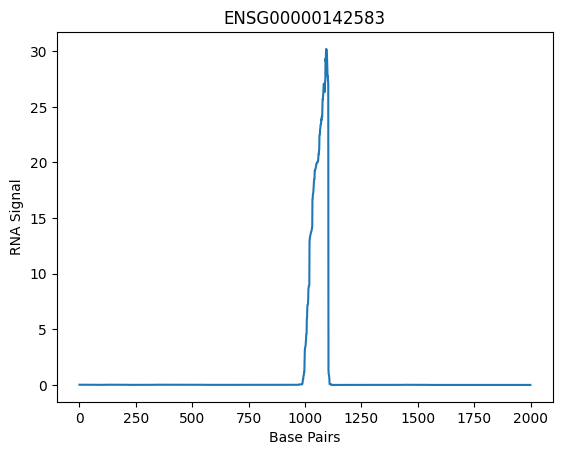

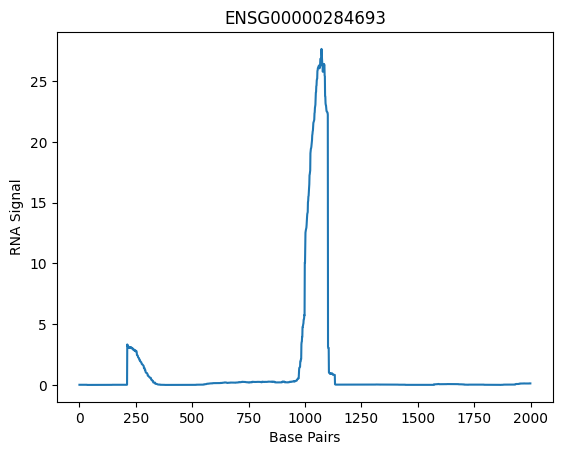

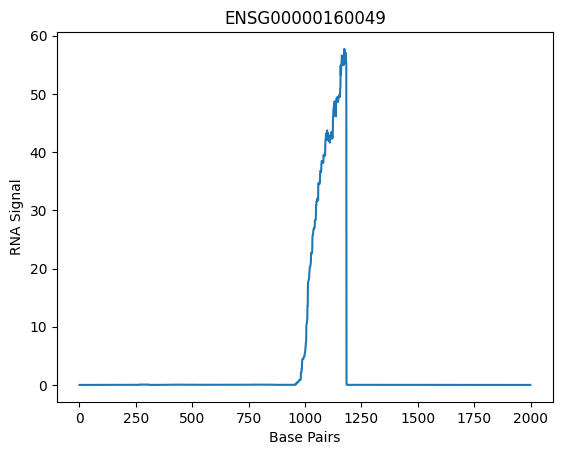

Threshold: 3.0
Number of Genes w/ Strong Peaks: 113


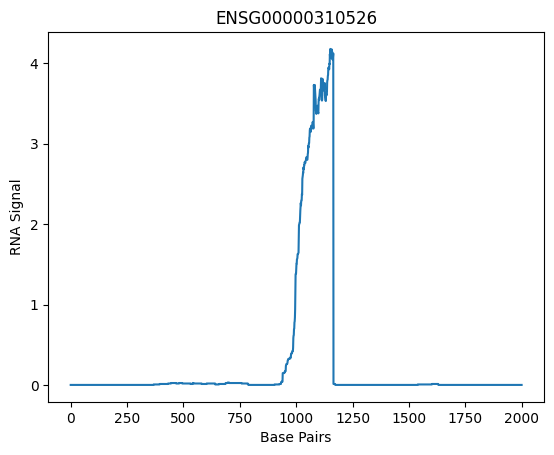

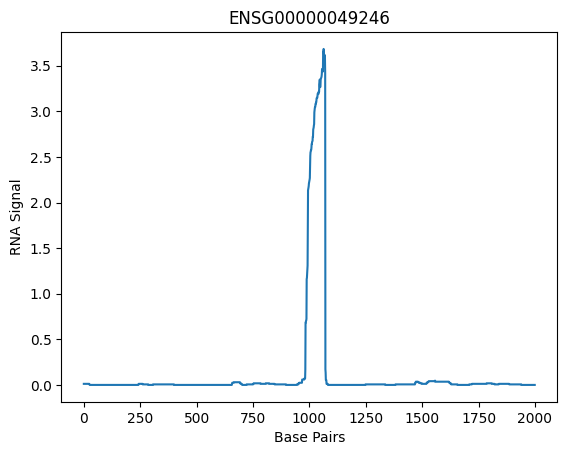

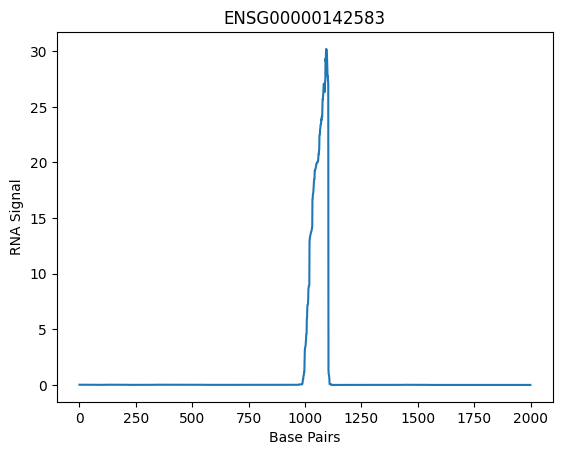

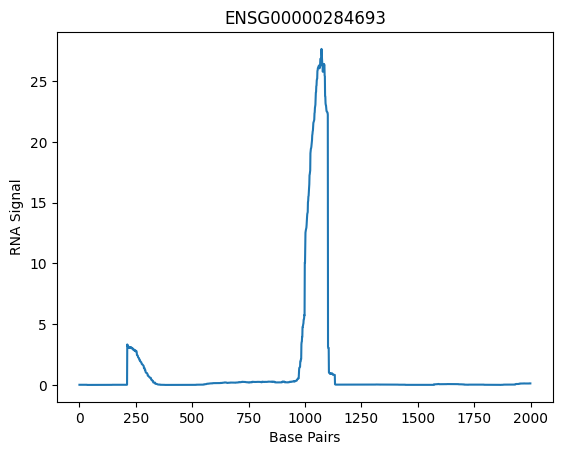

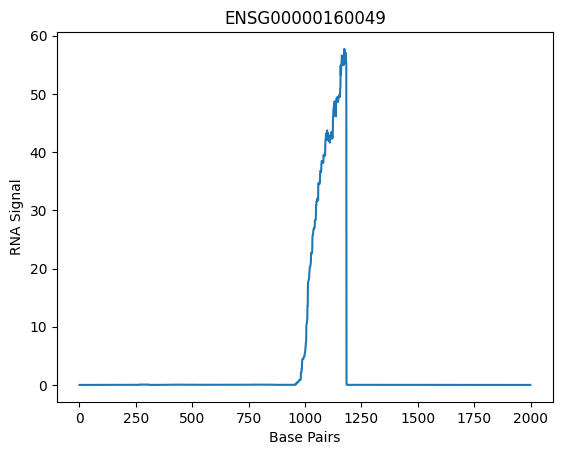

Threshold: 3.5
Number of Genes w/ Strong Peaks: 105


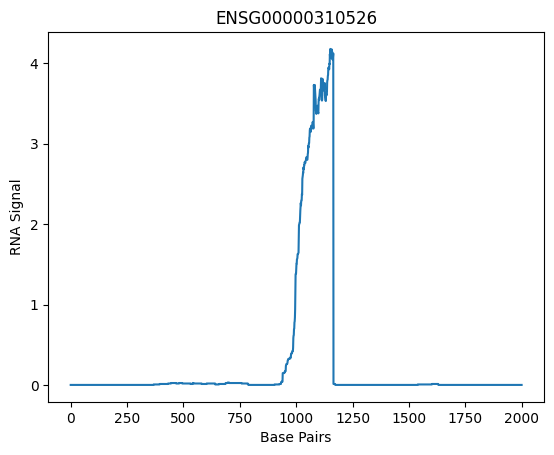

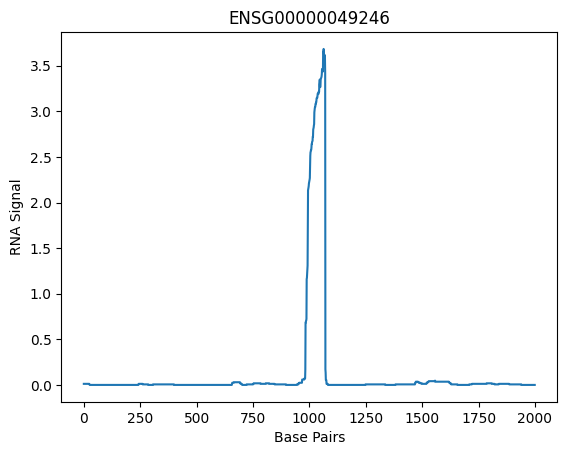

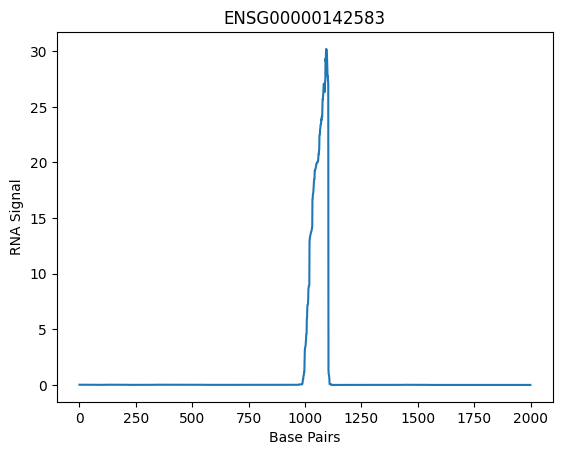

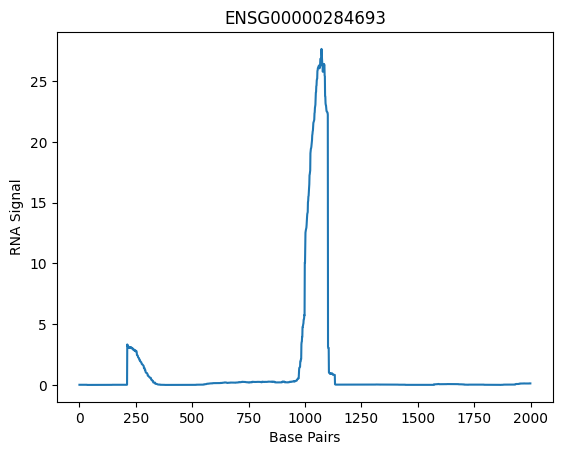

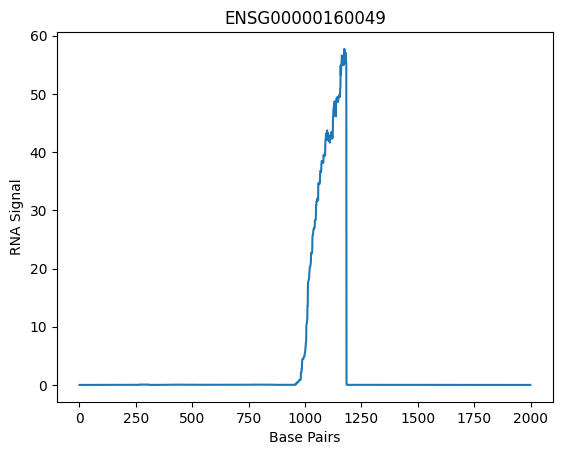

Threshold: 4.0
Number of Genes w/ Strong Peaks: 97


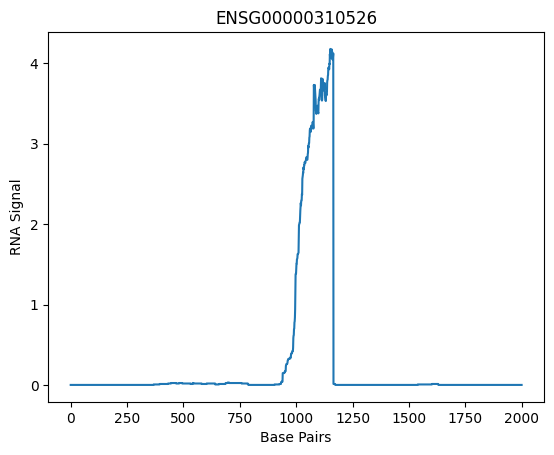

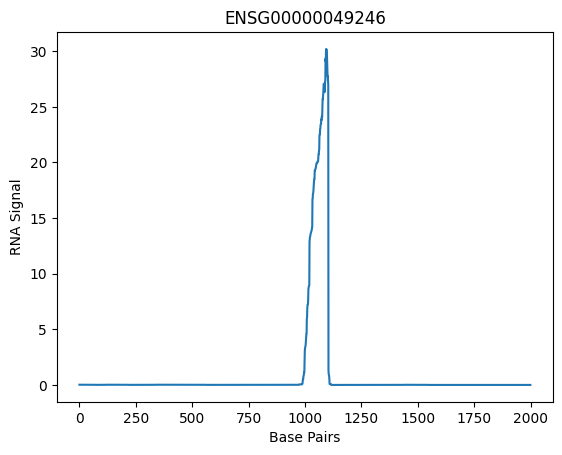

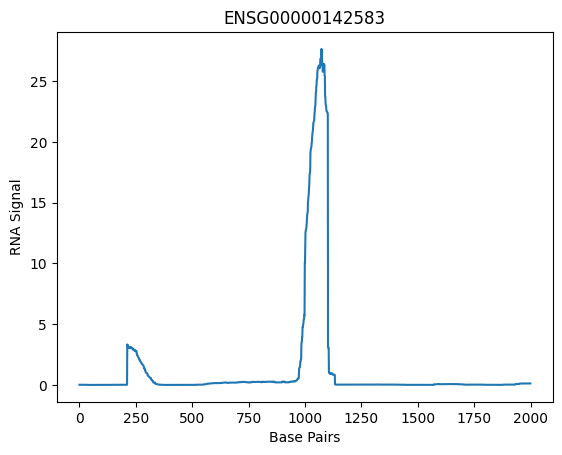

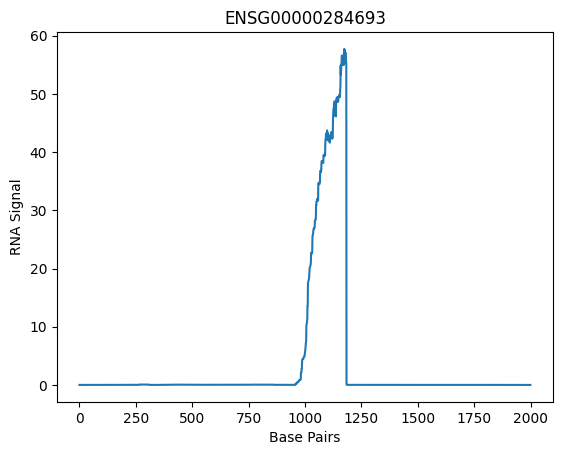

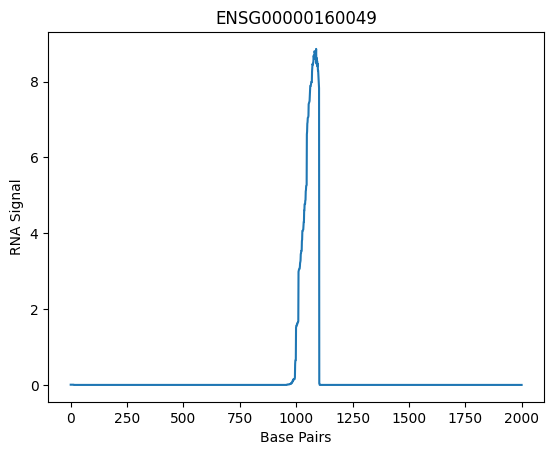

Threshold: 4.5
Number of Genes w/ Strong Peaks: 90


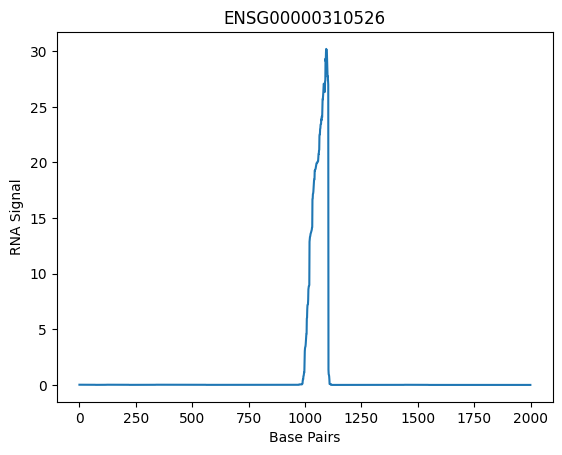

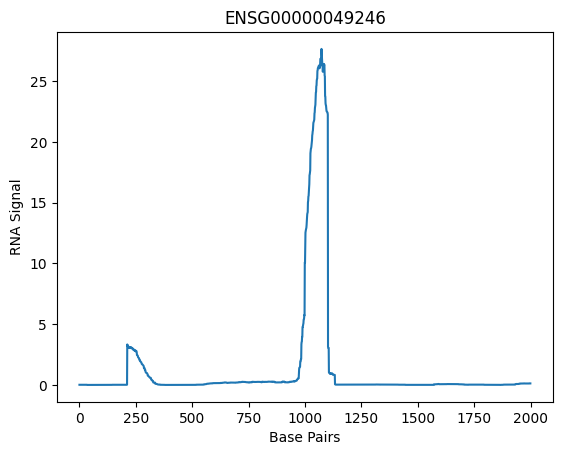

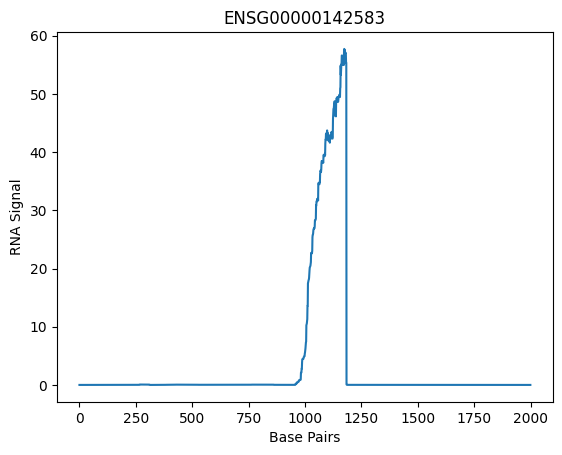

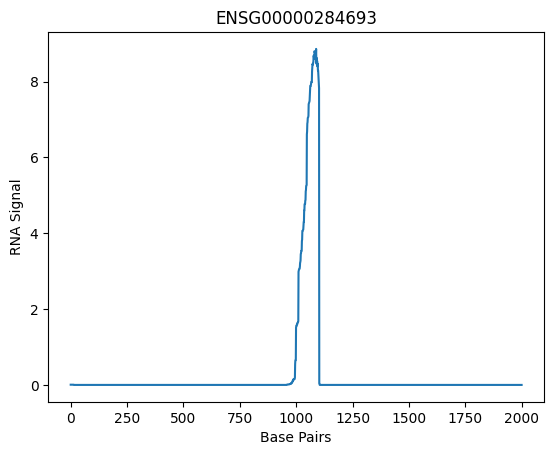

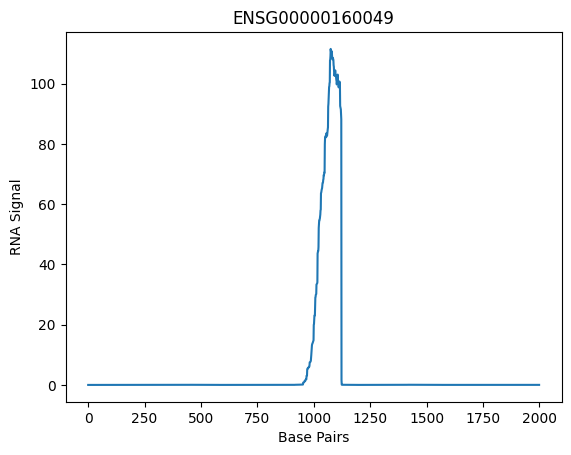

Threshold: 5.0
Number of Genes w/ Strong Peaks: 85


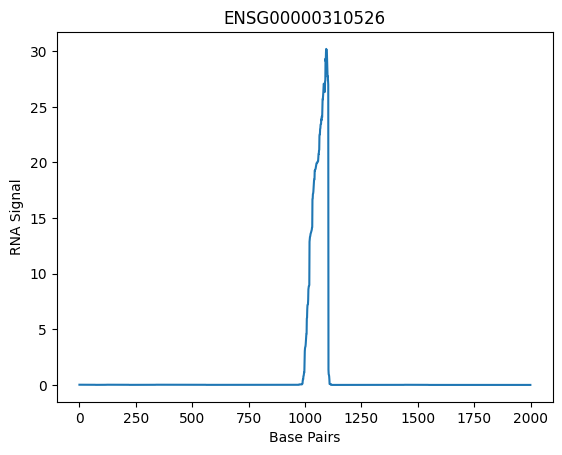

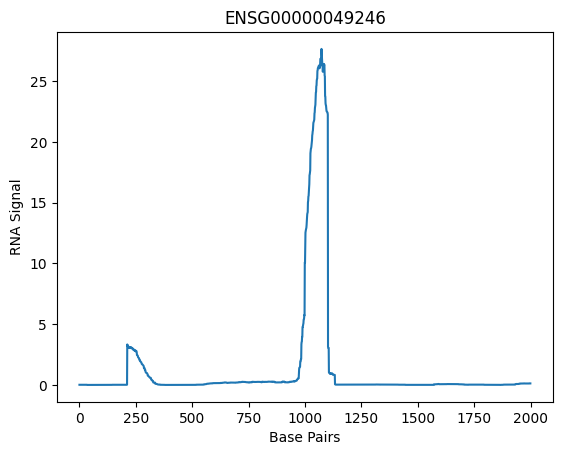

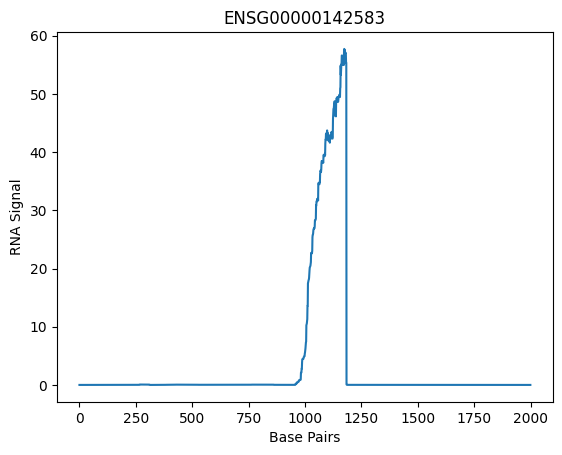

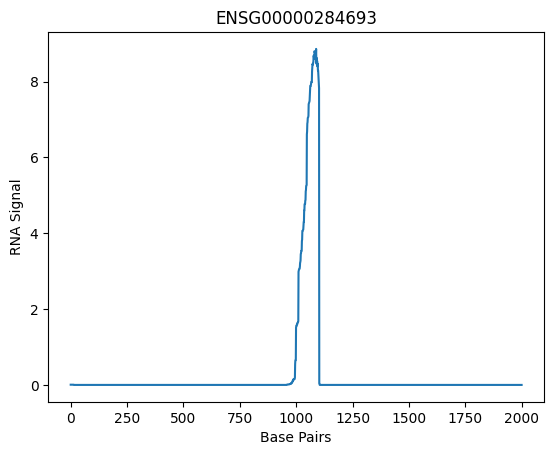

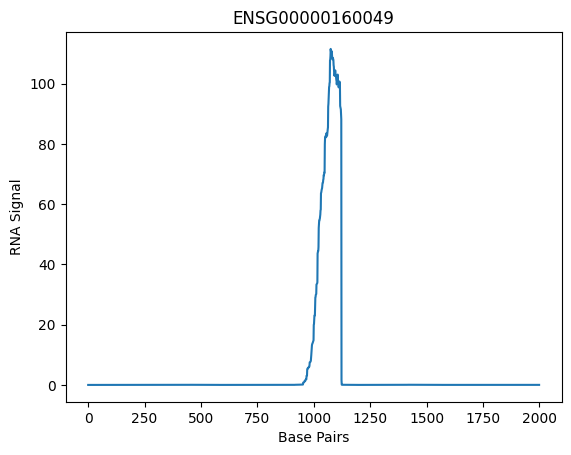

In [51]:
# GM12878
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_gm["ENSID"]) for gene in gm_h5["ensid"]]
rna = gm_h5["rna"][:][bool_df]
ensid = gm_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in gm_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(gm_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

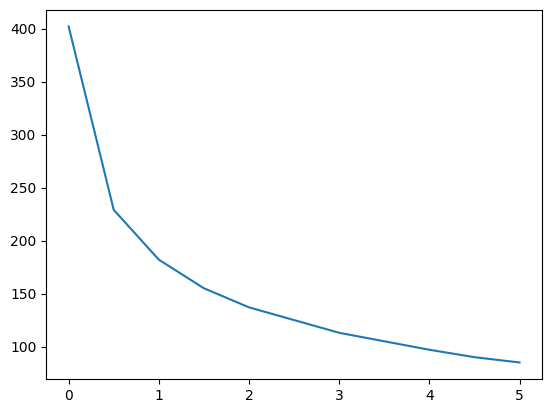

In [52]:
# GM12878
plt.plot(thresholds, peak_counts)

Threshold: 0.0
Number of Genes w/ Strong Peaks: 504


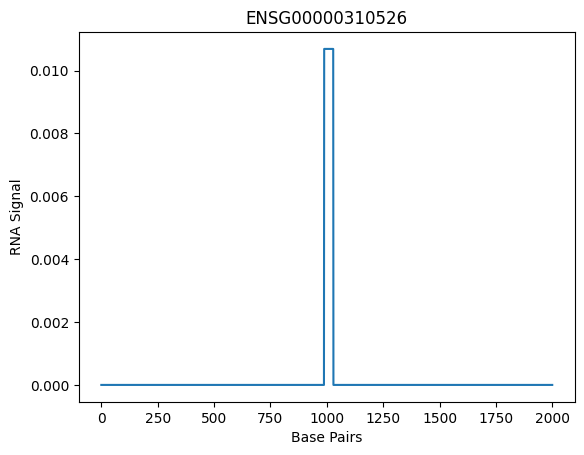

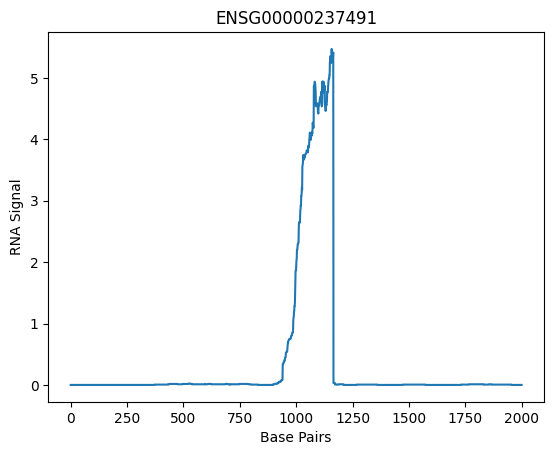

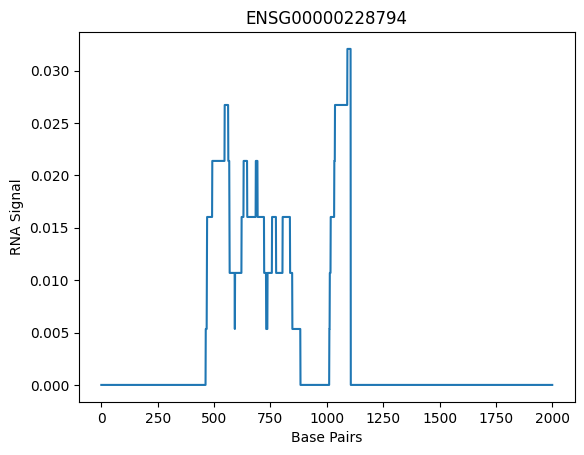

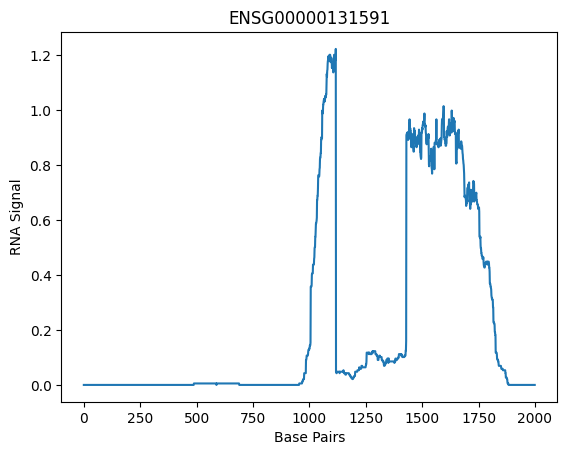

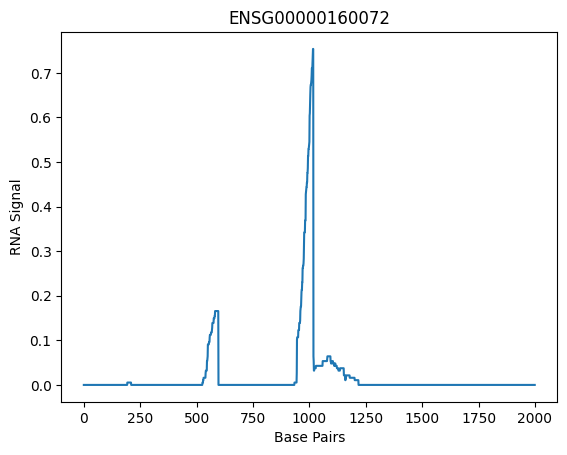

Threshold: 0.5
Number of Genes w/ Strong Peaks: 344


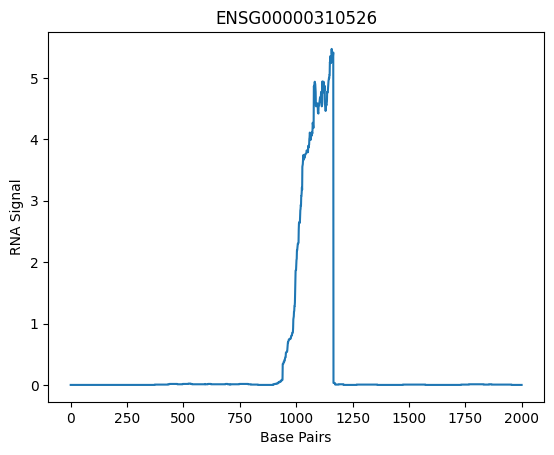

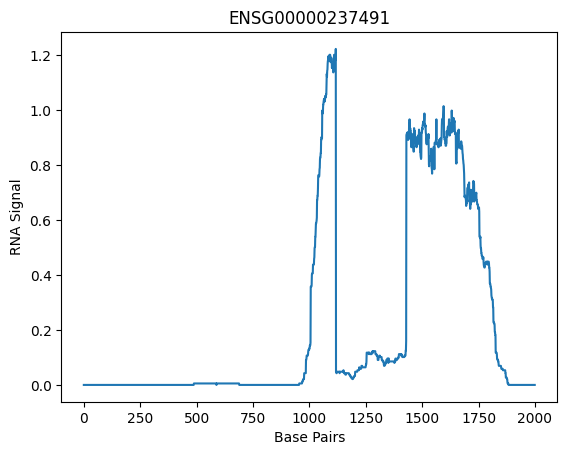

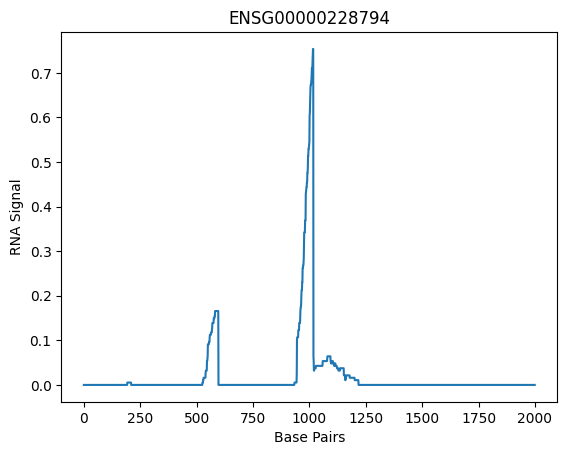

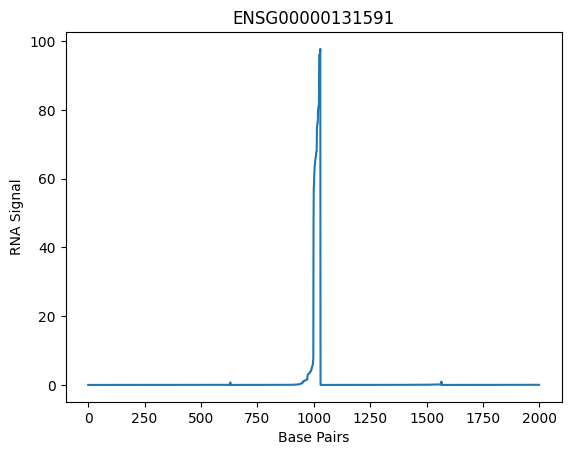

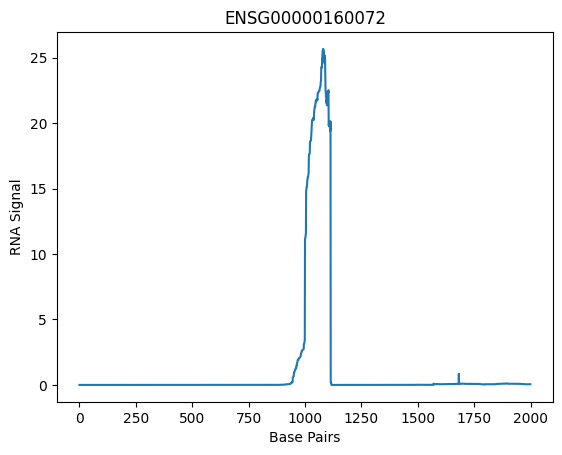

Threshold: 1.0
Number of Genes w/ Strong Peaks: 283


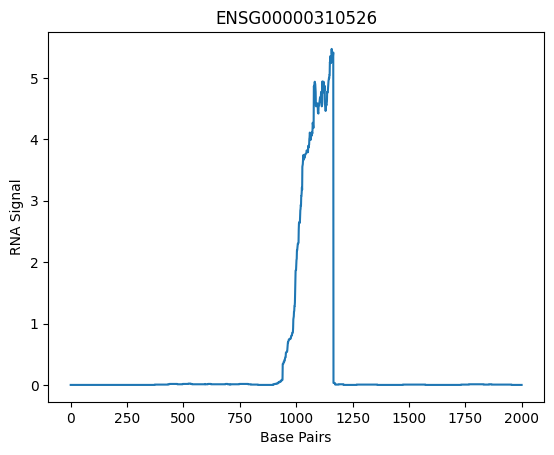

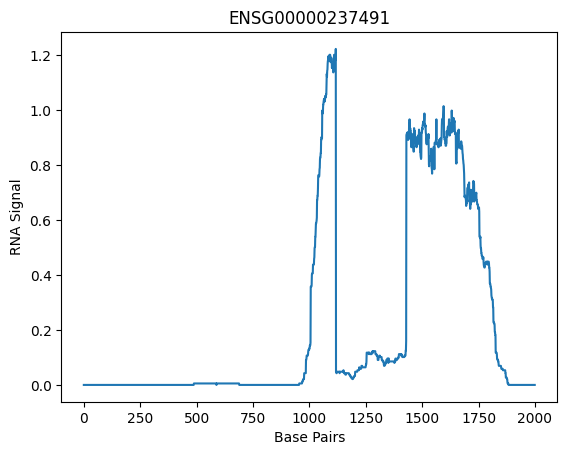

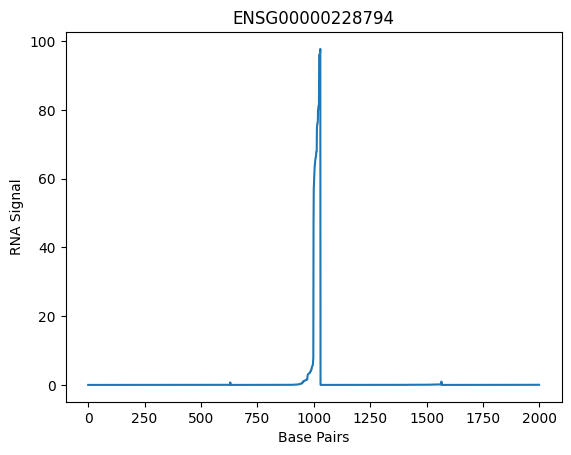

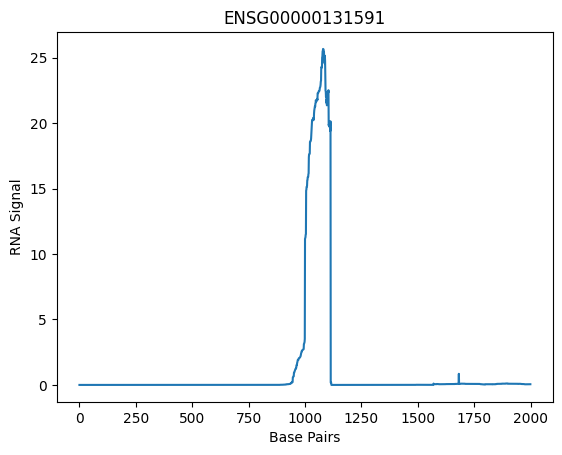

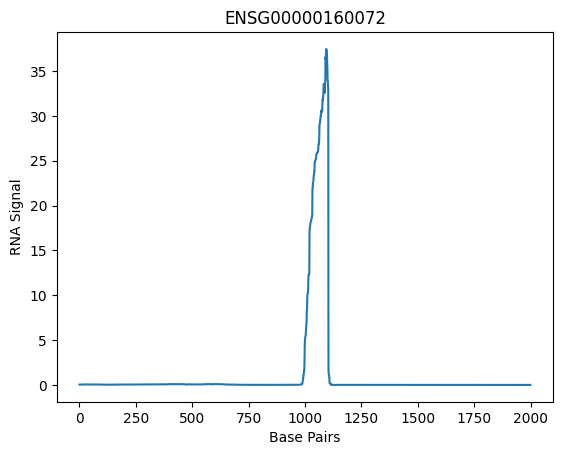

Threshold: 1.5
Number of Genes w/ Strong Peaks: 253


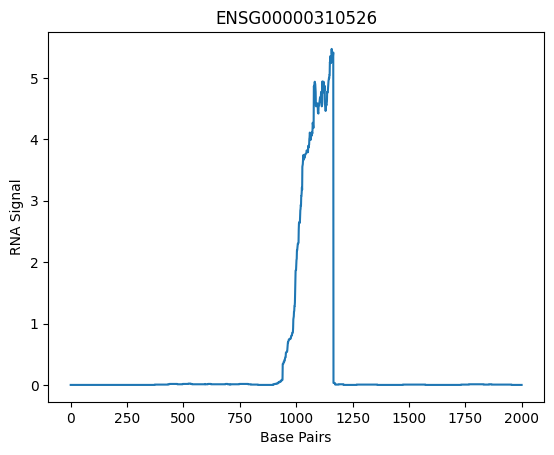

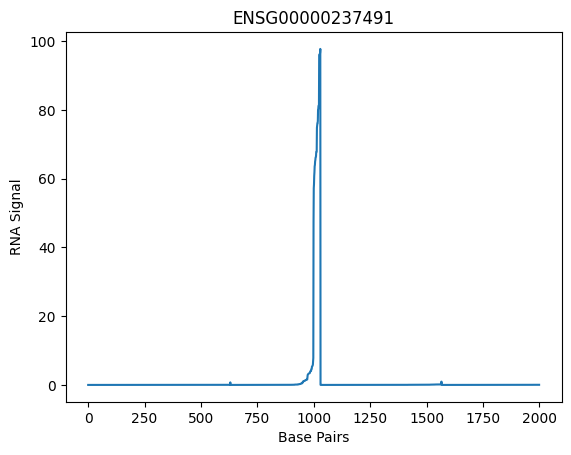

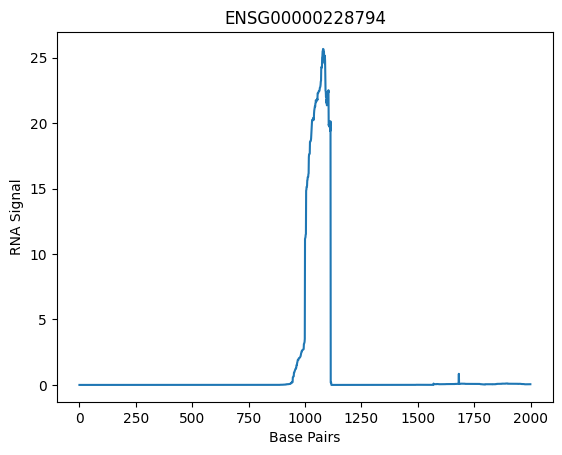

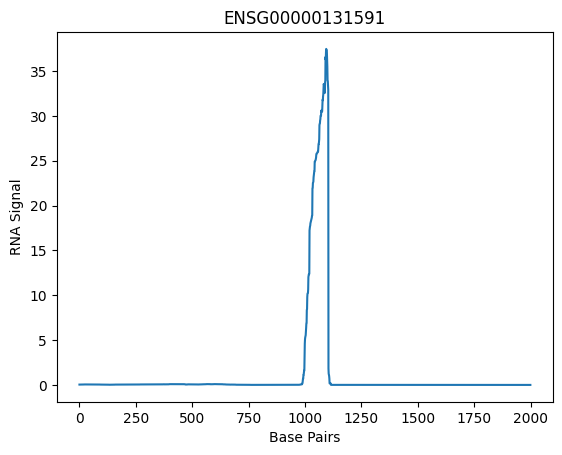

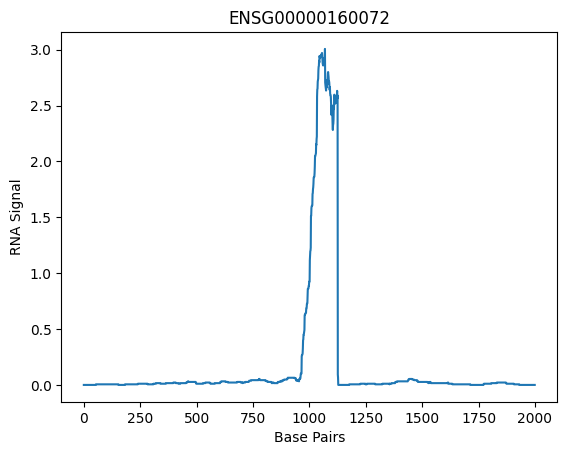

Threshold: 2.0
Number of Genes w/ Strong Peaks: 221


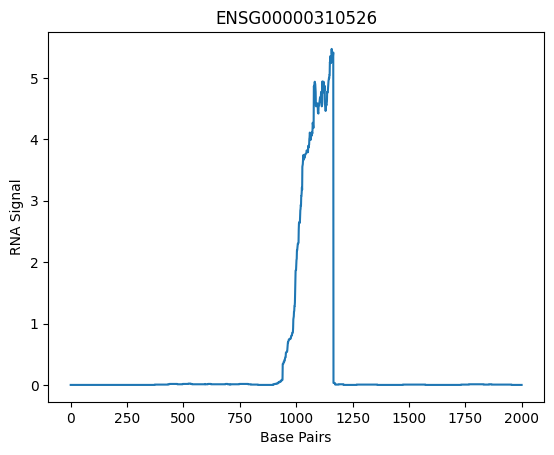

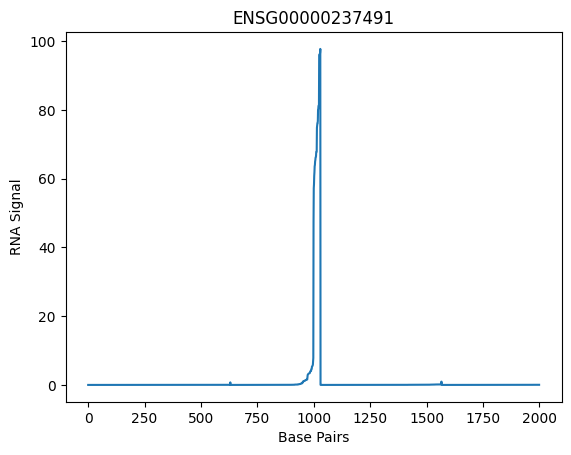

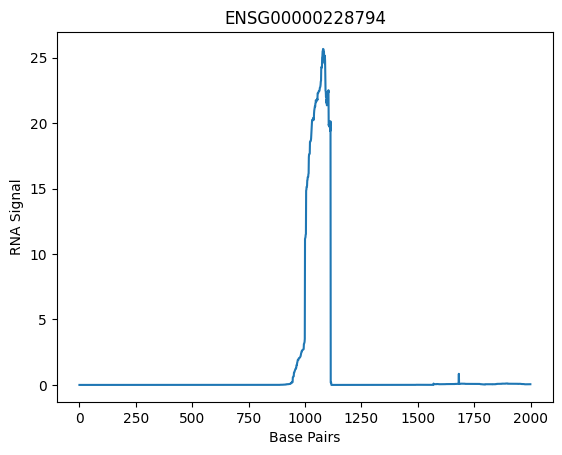

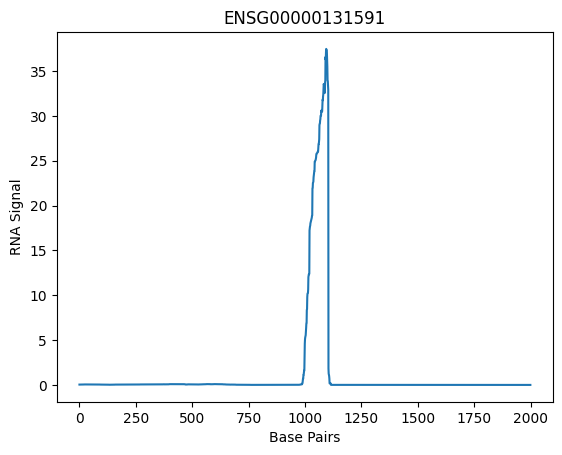

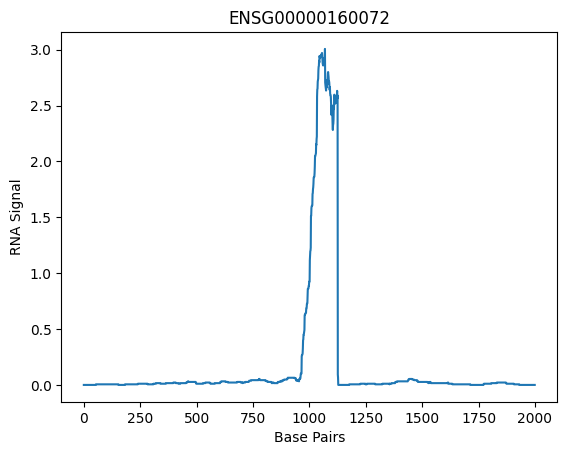

Threshold: 2.5
Number of Genes w/ Strong Peaks: 198


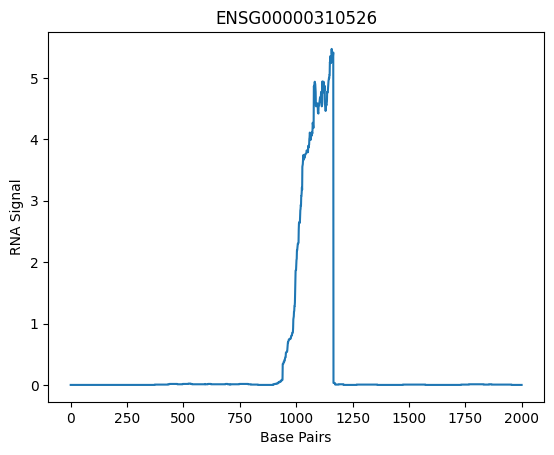

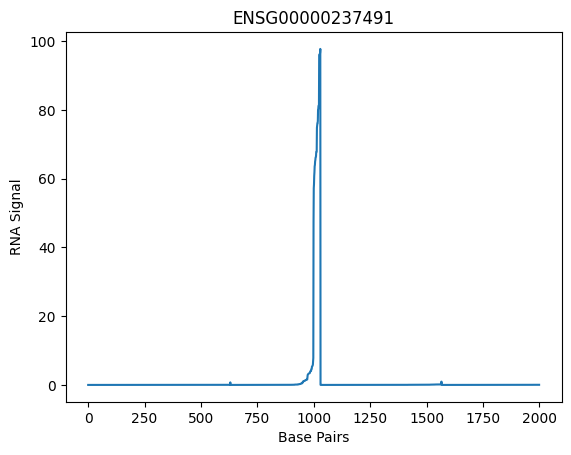

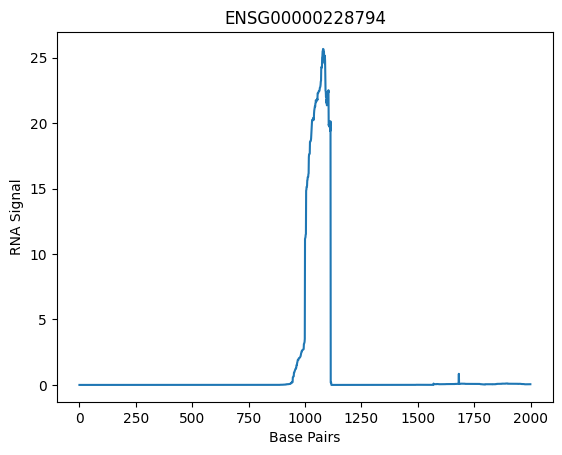

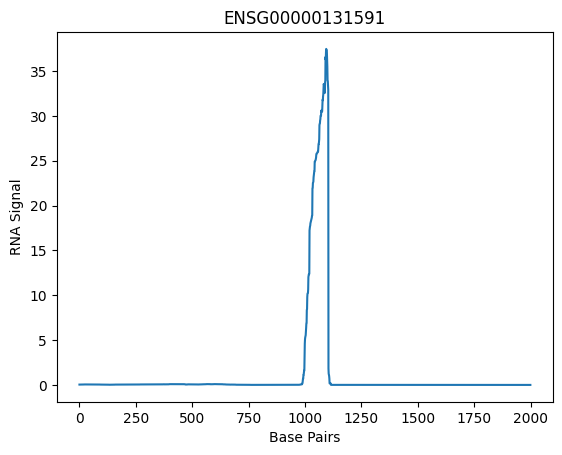

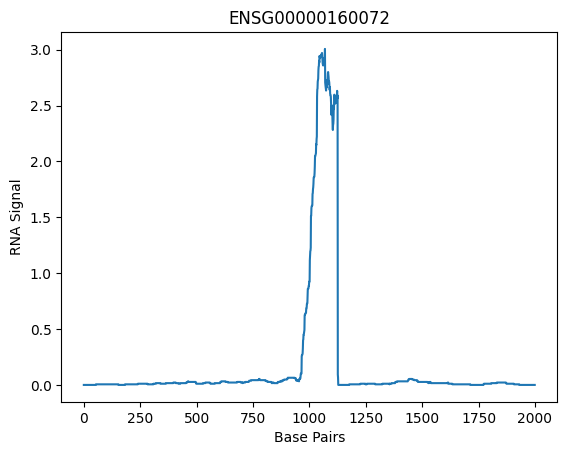

Threshold: 3.0
Number of Genes w/ Strong Peaks: 189


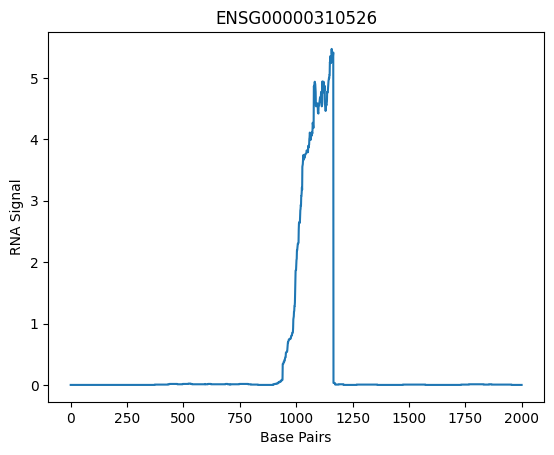

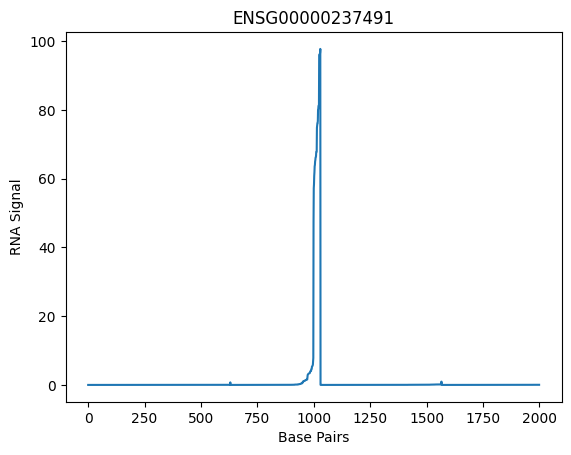

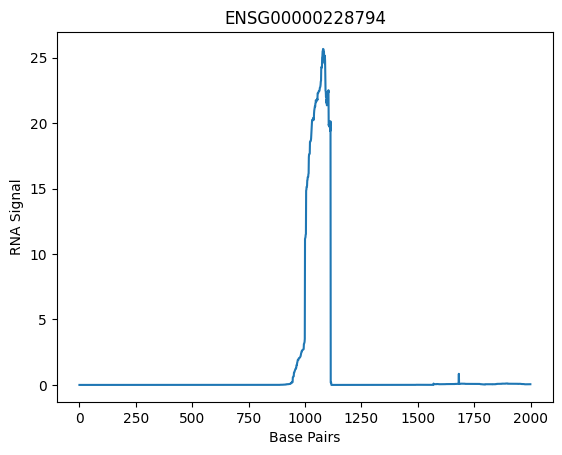

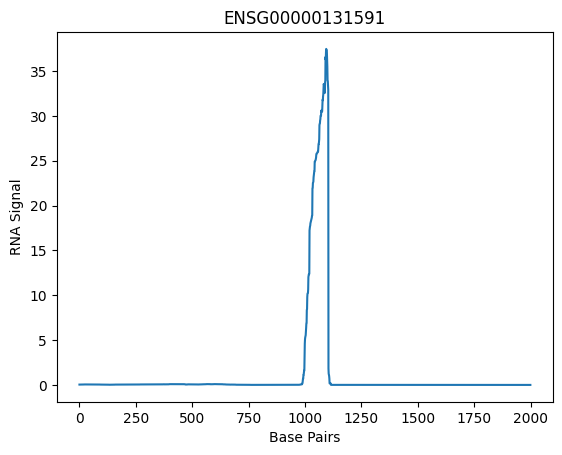

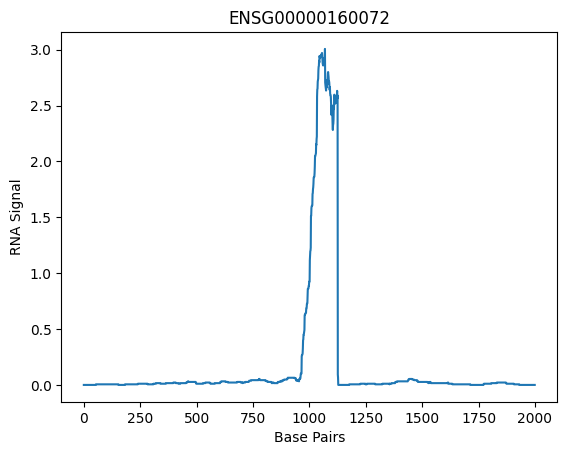

Threshold: 3.5
Number of Genes w/ Strong Peaks: 176


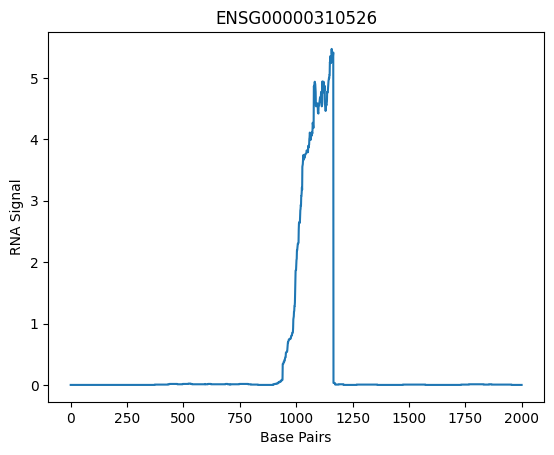

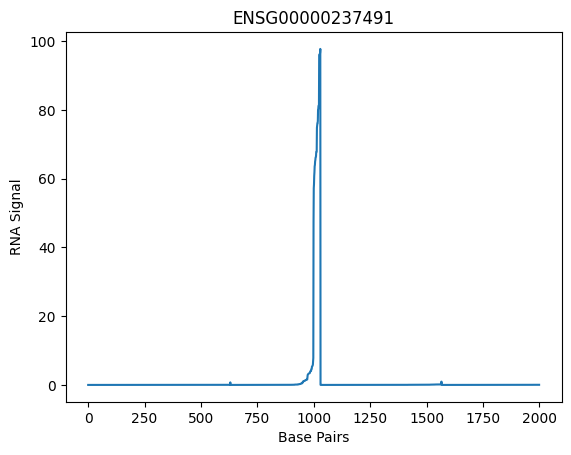

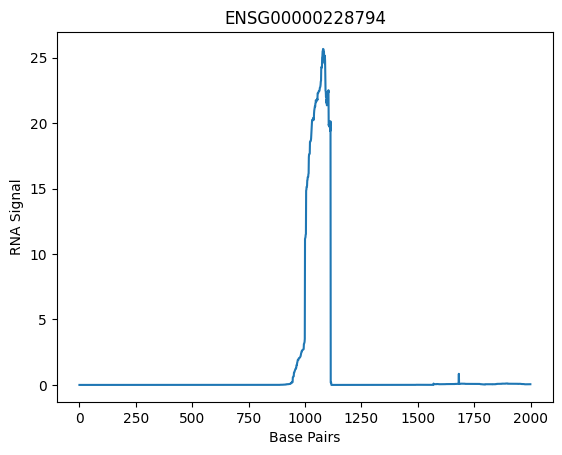

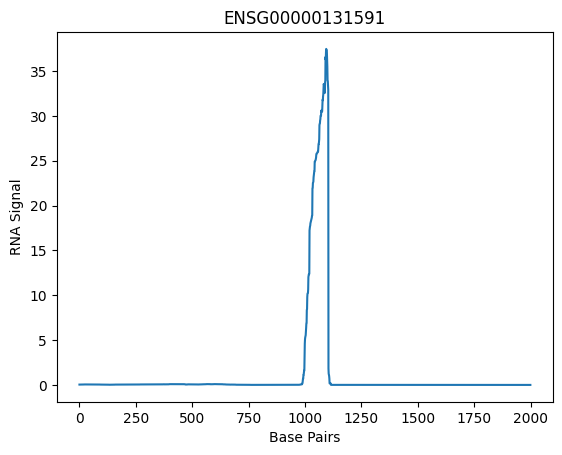

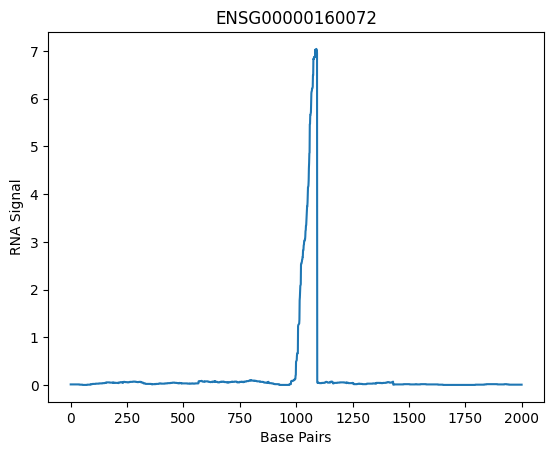

Threshold: 4.0
Number of Genes w/ Strong Peaks: 169


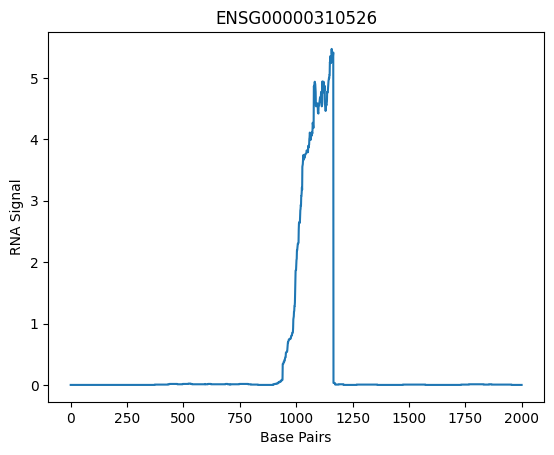

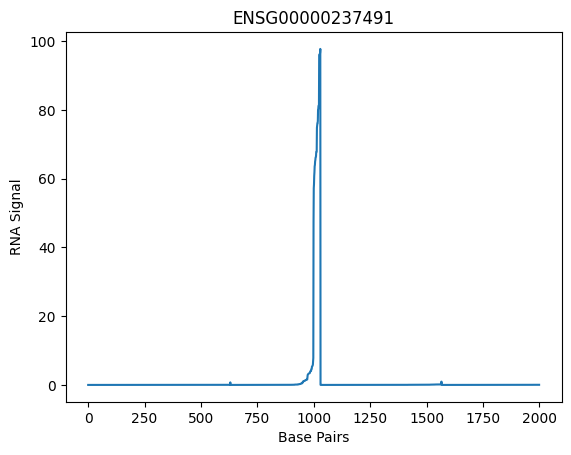

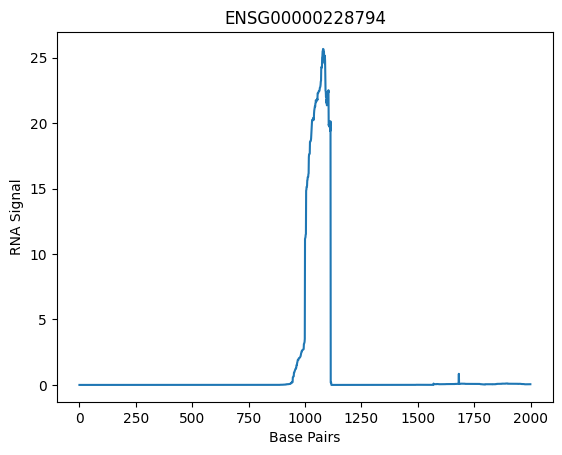

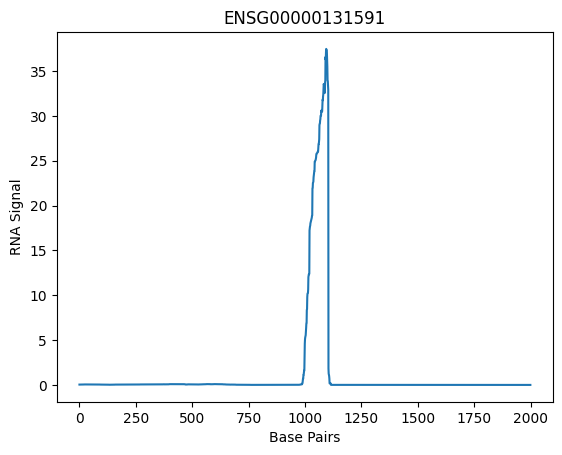

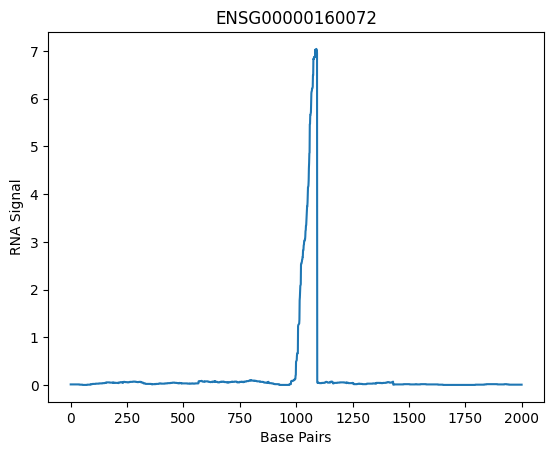

Threshold: 4.5
Number of Genes w/ Strong Peaks: 159


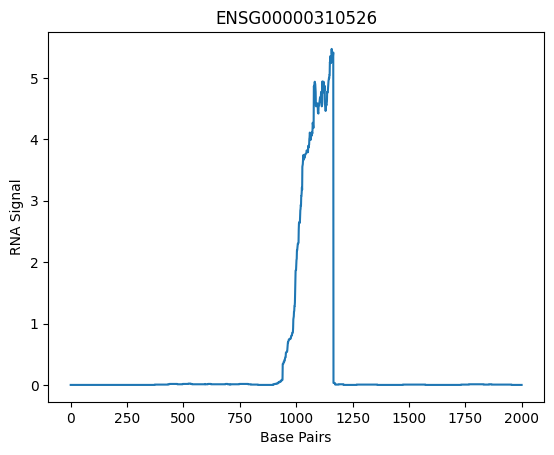

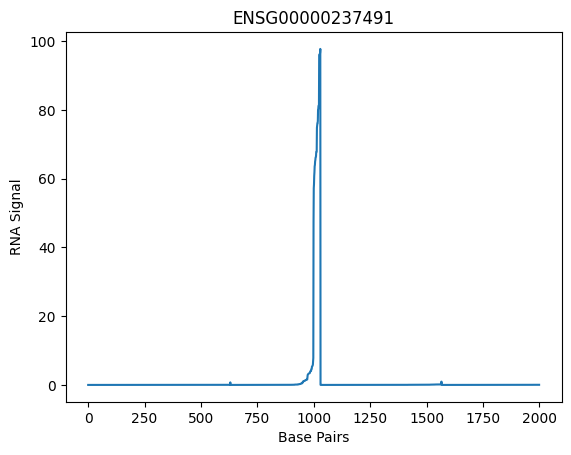

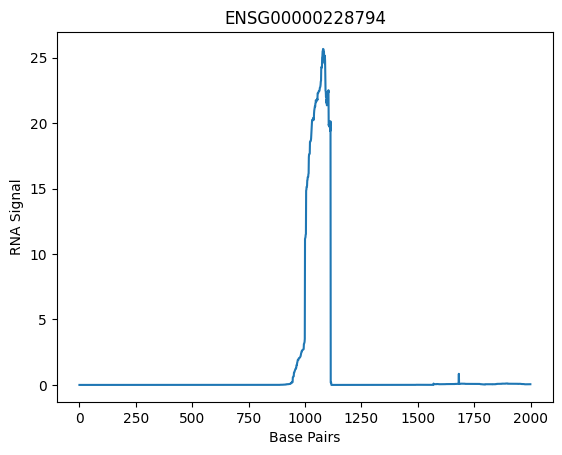

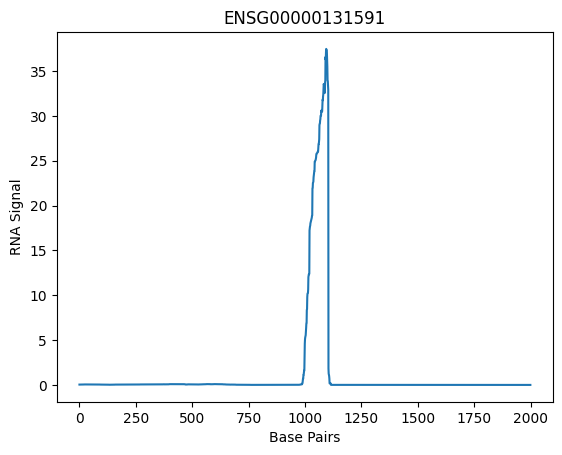

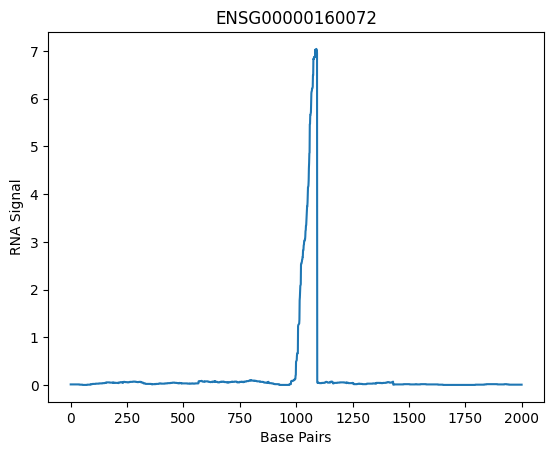

Threshold: 5.0
Number of Genes w/ Strong Peaks: 149


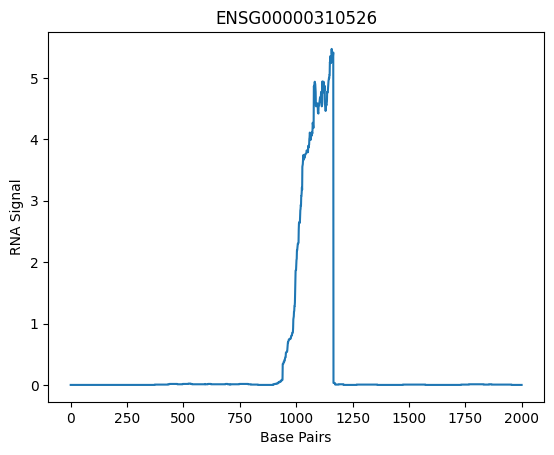

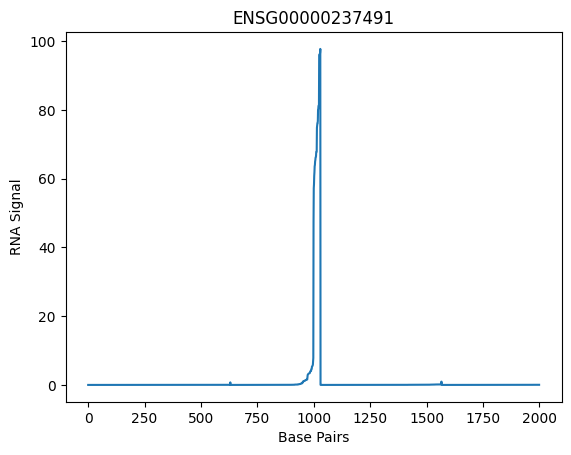

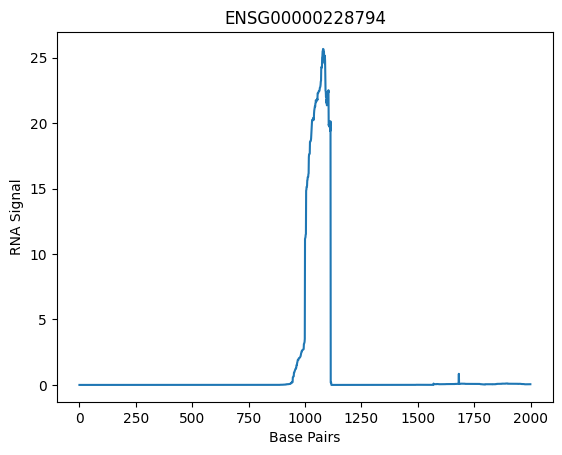

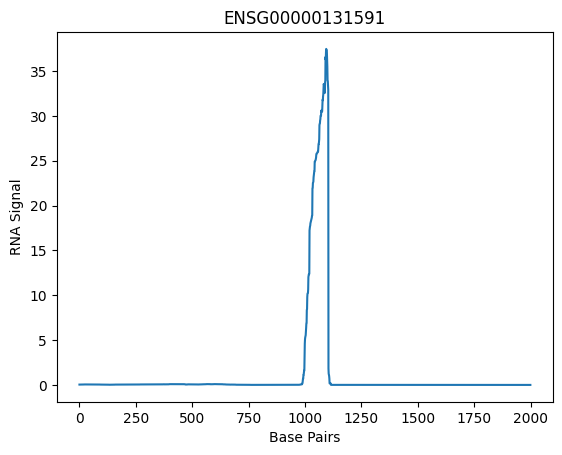

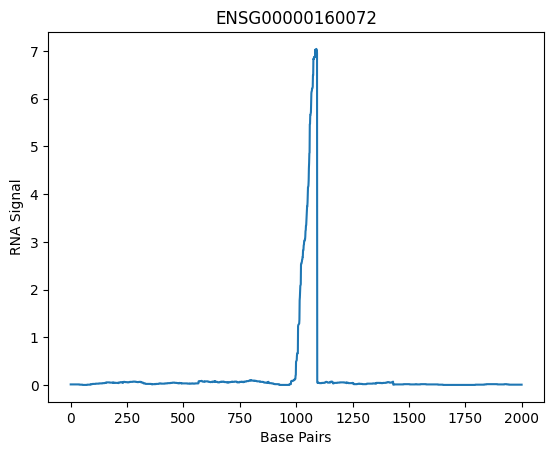

In [53]:
# K562
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_k5["ENSID"]) for gene in k5_h5["ensid"]]
rna = k5_h5["rna"][:][bool_df]
ensid = k5_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in k5_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(k5_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

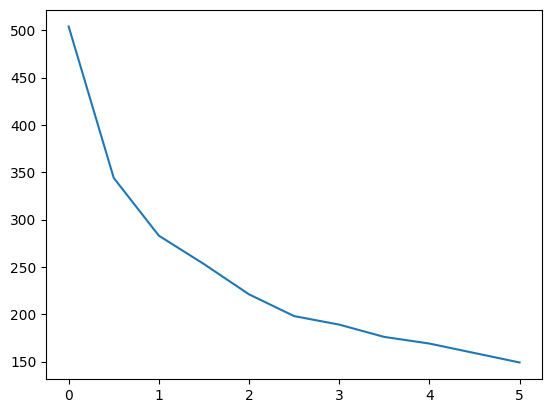

In [54]:
plt.plot(thresholds, peak_counts)

Aggregate Plots of Best Predictions

Threshold: 0.02, with 785 genes.


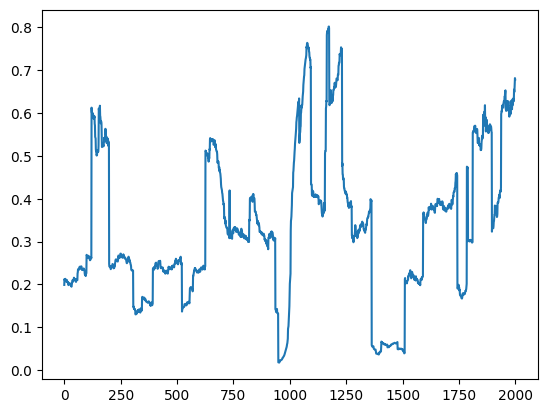

Threshold: 0.039999999999999994, with 1680 genes.


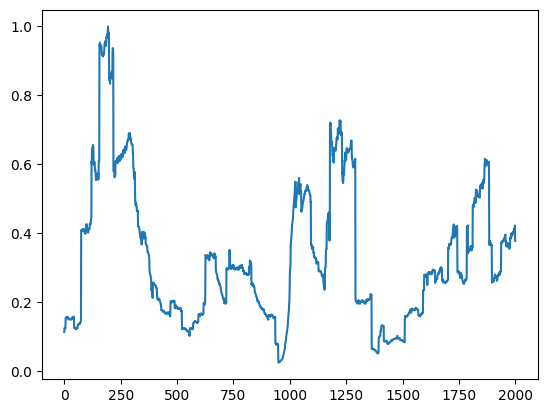

Threshold: 0.06, with 2660 genes.


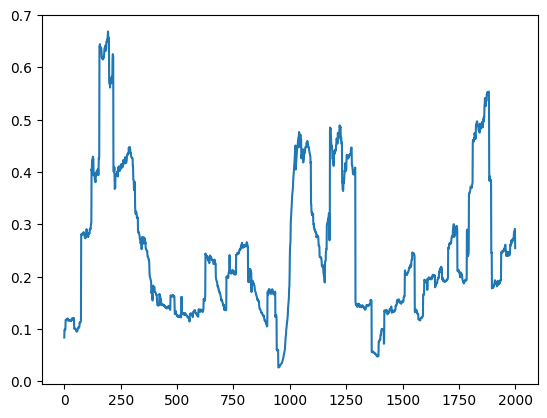

Threshold: 0.07999999999999999, with 3700 genes.


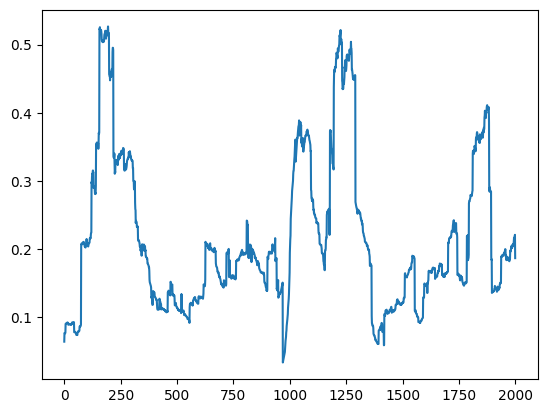

Threshold: 0.09999999999999999, with 4846 genes.


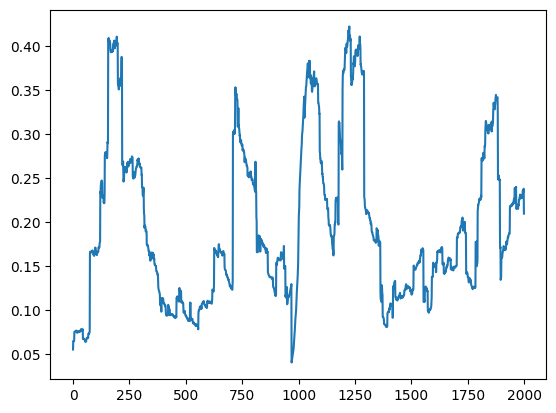

Threshold: 0.11999999999999998, with 6024 genes.


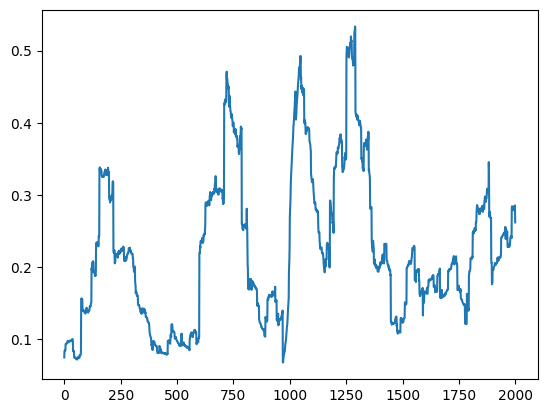

Threshold: 0.13999999999999999, with 7124 genes.


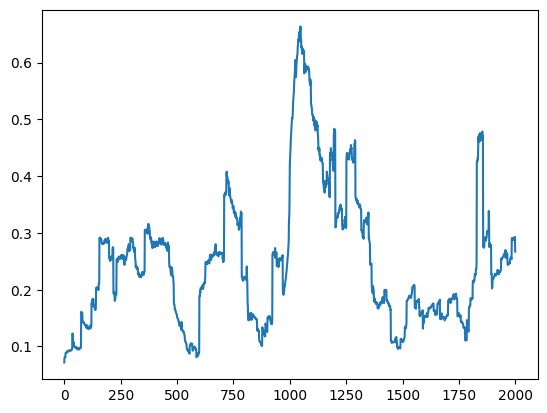

Threshold: 0.15999999999999998, with 8148 genes.


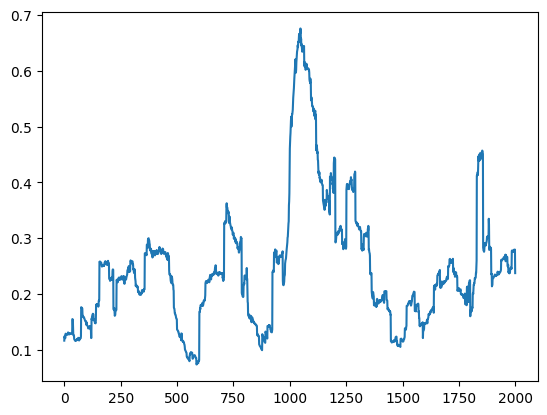

Threshold: 0.17999999999999997, with 9171 genes.


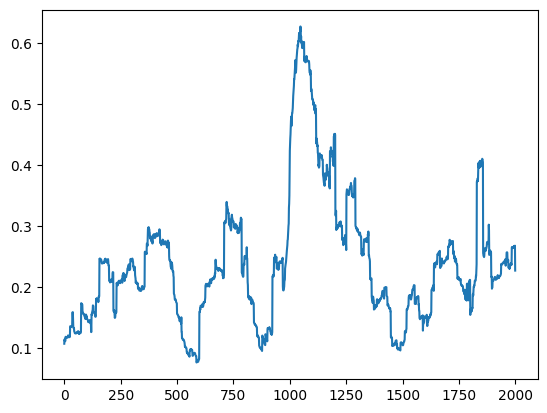

Threshold: 0.19999999999999996, with 10128 genes.


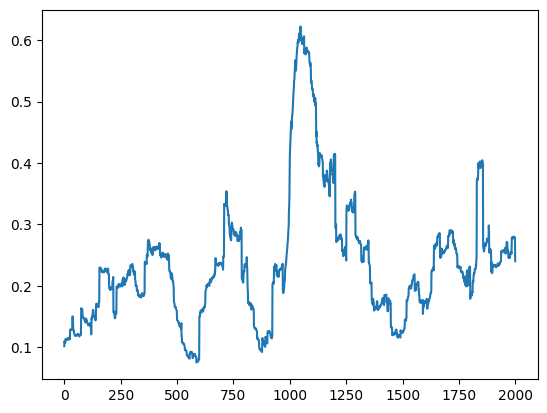

Threshold: 0.21999999999999995, with 11032 genes.


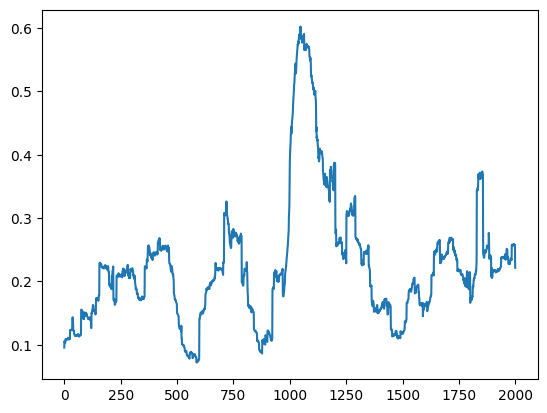

Threshold: 0.23999999999999996, with 11869 genes.


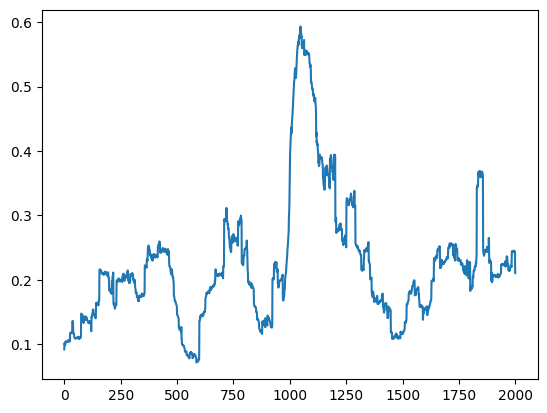

Threshold: 0.25999999999999995, with 12621 genes.


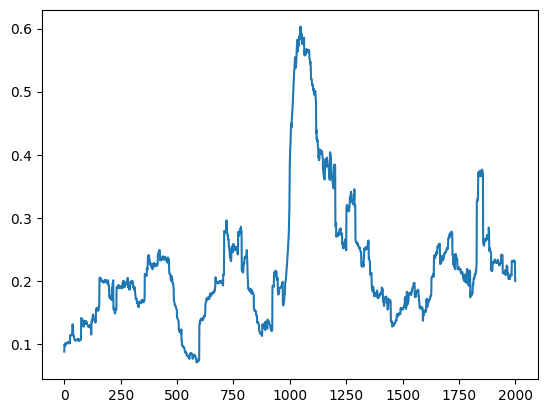

Threshold: 0.27999999999999997, with 13353 genes.


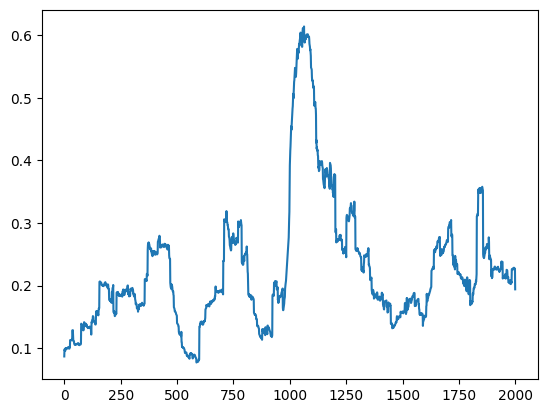

Threshold: 0.3, with 14057 genes.


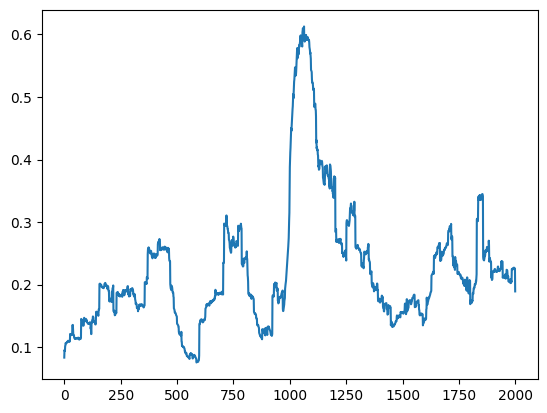

In [55]:
# GM12878
counts = []
thresholds = np.linspace(0.02, 0.3, 15)
for threshold in thresholds:
    best_gm = gm[gm["Error"] < threshold]

    bool_df = [gene.decode() in list(best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]
    ensid = gm_h5["ensid"][:][bool_df]
    rna = gm_h5["rna"][:][bool_df]

    counts.append(len(rna))
    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    plt.plot(np.mean(rna, axis=0))
    plt.show()


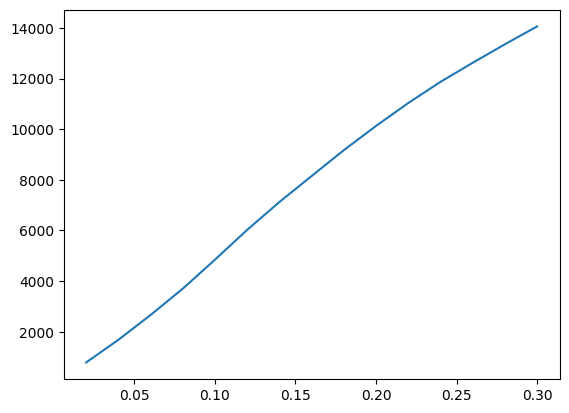

In [56]:
plt.plot(thresholds, counts)

Threshold: 0.01, with 824 genes.


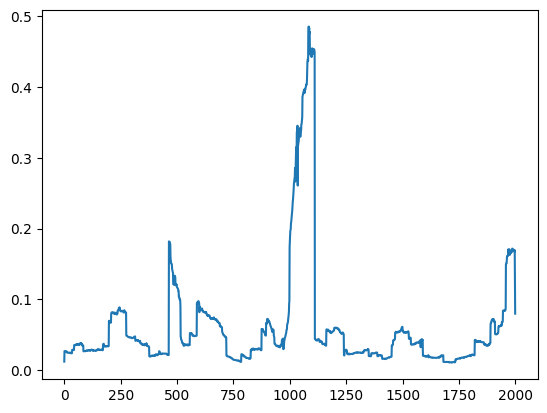

Threshold: 0.02, with 1601 genes.


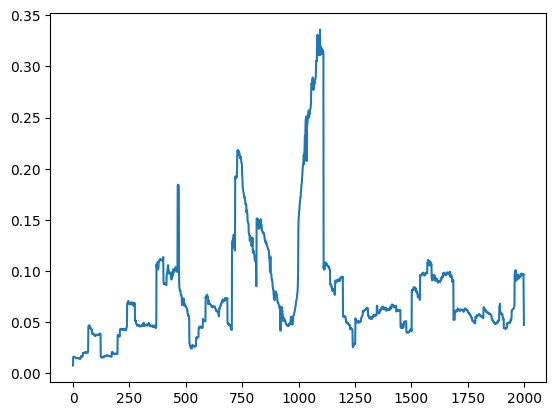

Threshold: 0.03, with 2430 genes.


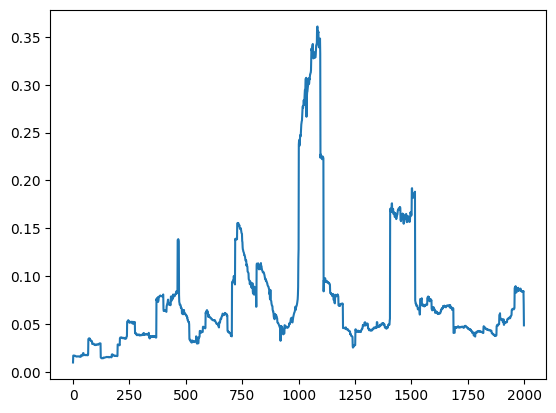

Threshold: 0.04, with 3186 genes.


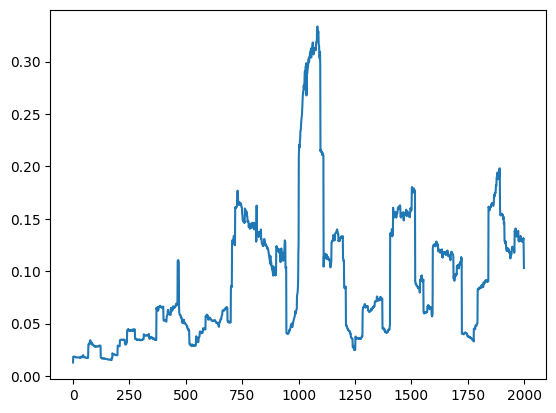

Threshold: 0.05, with 3885 genes.


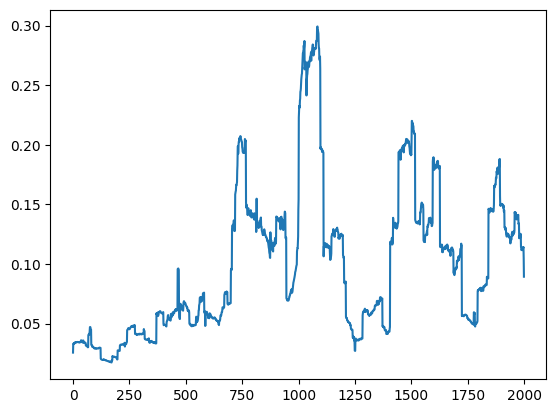

In [57]:
# K562
counts = []
thresholds = np.linspace(0.01, 0.05, 5)
for threshold in thresholds:
    best_k5 = k5[k5["Error"] < threshold]

    bool_df = [gene.decode() in list(best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]
    ensid = k5_h5["ensid"][:][bool_df]
    rna = k5_h5["rna"][:][bool_df]

    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    counts.append(len(rna))
    plt.plot(np.mean(rna, axis=0))
    plt.show()

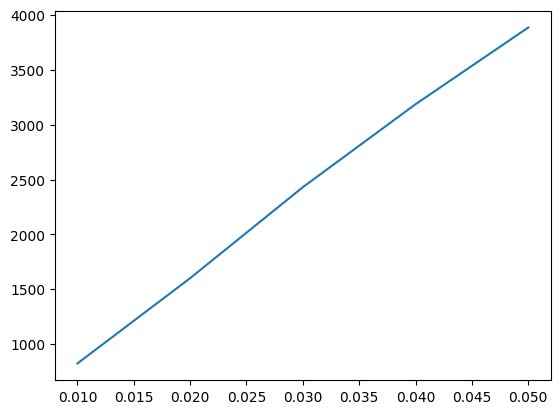

In [58]:
plt.plot(thresholds, counts)

List of Genes for K562 (Error < 0.01)

In [59]:
# k5[k5["Error"] < 0.01]["Unnamed: 0"].to_csv("k562.001.txt", header=False, index=None, sep=" ")

List of Genes for K562 (Set Difference Between Error < 0.03 and Error < 0.04)

In [60]:
# k5_003 = k5[k5["Error"] < 0.03]["Unnamed: 0"]
# k5_004 = k5[k5["Error"] < 0.04]["Unnamed: 0"]

In [61]:
# diff_003_004 = k5_004[~k5_004.isin(k5_003)]
# k5_004[~k5_004.isin(k5_003)].to_csv("k562.003_004_diff.txt", header=False, index=None, sep=" ")

Identify Outliers in the Set Difference

In [62]:
# bool_df = [gene.decode() in list(diff_003_004) for gene in k5_h5["ensid"]]
# rna = k5_h5["rna"][:][bool_df]
# ensid = k5_h5["ensid"][:][bool_df]

In [63]:
# with open("k5_003_004_outliers.txt", "a") as file:
#     for idx, sig in enumerate(rna):
#         if np.max(sig) > 1 and np.max(sig) in sig[450:900]:
#             file.write(f"{ensid[idx].decode()}\n")

        